# Multi Salmo microbetag networks analysis

## Dependencies

In [2]:
import os
import pickle 
import itertools
import numpy as np 
import pandas as pd 
import warnings,logging
from pathlib import Path

# Plotting
from plotnine import stat_smooth
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import plotly.io as pio
import plotly.express as px
import webbrowser
from IPython.display import display, Markdown

# Utils
from utils import *

# Met model
import cobra

In [3]:
# Will take some time! 
root_dir   = Path(".").parent.parent.resolve()
mgg_prec   = root_dir / "mgg_prec"
genres_dir = mgg_prec / "reconstructions/GENREs"

In [4]:
genome_quality  = pd.read_csv("../data/genomeInfo.csv")

In [5]:
genome_size = genome_quality["length"].values.tolist()

In [6]:
genome_quality[genome_quality["length"] < 1e6].shape
genome_quality[genome_quality["length"] > 1e7].shape

(1, 5)

In [7]:
abundance_file   = "abundance_prev20.tsv"
taxonomy_file    = "salm_multio_abd_table_gc.tsv"
metadata_file    = "metadata_prev_0.0_overall.tsv"
metabolites_file = "original_mets_data_20250113.xlsx"
template_config  = "config_v104.yml"

Load libraries and set root paths.

In [8]:
root            = Path(os.getcwd())
input_data      = root / "data"
microbetag_data = root / "microbetag_input/"

Load abundance data

In [9]:
abd = pd.read_csv(microbetag_data / abundance_file, index_col=0)
abd.head(2)

,D300529,D300480,D300517,D300428,D300509,D300516,D300510,D300483,D300466,D300421,...,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497,classification
genome,,,,,,,,,,,,,,,,,,,,,
D300430:bin_000010,2.607789,4.819473,3.286938,17.597362,10.291956,10.220982,4.596655,7.567160,6.932594,9.753904,...,16.838742,23.439109,10.233177,7.759339,12.926734,5.729738,12.526382,5.296297,0.000000,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
D300435:bin_000001,5.731787,28.447043,16.463287,35.044484,12.310726,26.633593,25.525289,25.900106,6.400694,16.025952,...,27.307332,18.632932,12.471707,1.848686,6.176369,7.833729,2.830775,0.000000,4.341884,d__Bacteria;p__Bacillota_A;c__Clostridia;o__La...


Load metadata file, mapping samples to their corresponding treatment and day.
In the following table we provide a short description of the treatments. 

|  Factor        |	TG1 | TG2 |	TG3 | TG4 | TG5 |
|:--------------:|:----:|:---:|:---:|:---:|:---:|
|salmonella	     | Yes	| Yes | Yes | Yes | No  |
|synbiotic_water | Yes	| Yes |	No  | No  |	No  |
|synbiotic_feed	 | Yes	| No  |	Yes | No  | No  |



In [10]:
metadata    = pd.read_csv(microbetag_data / metadata_file, sep="\t")
metabolites = metadata[4:]
metabolites.rename(columns={"sample":"metabolite"}, inplace=True)

/tmp/ipykernel_18124/1378749774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In the metabolites file, you may see that a great number of metabolites were measured in the study, however we selected the most relevant that could affect the samples' communities, and we kept their values in the 'of-interest' sheet.

We will now merge the metabolites' data with the rest of the metadata of each sample, so we use their combination to infer microbial co-occurrence networks with FlashWeave. 
To this end, we will use the `animal` column of the metadata, that has been used as the sample name for the metabolites' measurements. 

In [11]:
metabolites.index = metabolites["metabolite"]

In [12]:
metabolites = metabolites.iloc[:, 1:]

In [17]:
metadata.head()

,sample,D300418,D300419,D300420,D300421,D300422,D300423,D300424,D300425,D300426,...,D300520,D300521,D300522,D300523,D300524,D300525,D300526,D300527,D300528,D300529
0,animal_x,G041,G026,G004,G013,G073,G058,G062,G063,G070,...,G118,G099,G084,G071,G115,G011,G096,G037,G030,G024
1,treatment,TG2,TG2,TG1,TG1,TG3,TG3,TG3,TG3,TG3,...,TG5,TG4,TG4,TG3,TG5,TG1,TG4,TG2,TG2,TG1
2,day,28,7,7,28,35,14,21,21,28,...,28,35,14,35,28,21,35,21,14,35
3,type_simple,P,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
4,L-Asparagine,41717.3822180341,5957.40979346533,4115.37791503571,42407.5366733871,51363.1497354544,12634.5203968611,17431.9401239709,6064.47331125641,38157.8584709551,...,44964.1460312401,110969.647290303,121933.871269902,55797.8263877972,41837.4758089825,27343.0337577049,78333.6641326378,19526.5222565585,9066.72707451946,90921.760957879


In [18]:
metadata = metadata.T

In [19]:
metadata.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
sample,animal_x,treatment,day,type_simple,L-Asparagine,L-Glutamic acid,Pantothenic acid,L-Alanine,L-Serine,L-Proline,...,L-Histidine,L-Phenylalanine,Pyridoxamine,Pyridoxine,L-Arginine,L-Tyrosine,L-Tryptophan,Thiamine,Riboflavin,a-Tocopheryl acetate
D300418,G041,TG2,28,P,41717.3822180341,4108355.08156706,30849.8221000725,29915.8367929578,195481.295375394,14417076.0802165,...,1057888.27271522,1066576.88612189,646390.725258399,3974828.69197762,6445564.43508063,737906.120485865,724290.356057351,397258.466691091,1796730.5747134,4357249.06023359
D300419,G026,TG2,7,P,5957.40979346533,2287696.48645996,466217.912693091,66329.3392458584,333276.945045427,30786392.0364292,...,929033.709911488,21991965.2249056,1840993.36020706,4963150.73574374,5267436.90018537,2938962.83675836,1782147.95886323,6342834.24454076,86096.8694946204,2617423.75883697
D300420,G004,TG1,7,P,4115.37791503571,3724094.18178522,779530.896748074,16081.621975924,100603.168184739,122048336.33707,...,585351.546441363,817680.78941111,958096.893391971,5335448.86312373,4477350.14516451,376374.231336048,838408.858547822,398817.559582186,201823.358612819,4826150.13047076
D300421,G013,TG1,28,P,42407.5366733871,3384924.72778087,30539.6678355151,34946.6193020637,279523.764607492,16908091.3995128,...,2125533.96878918,528435.039831676,345111.695915348,3317341.89509854,4422529.02984121,407624.366220221,516201.872562084,333257.008480889,1961506.32741332,6049713.01967574


In [20]:
metadata.columns = metadata.iloc[0,:]
metadata = metadata.iloc[1:,]

In [21]:
metadata.head(2)

sample,animal_x,treatment,day,type_simple,L-Asparagine,L-Glutamic acid,Pantothenic acid,L-Alanine,L-Serine,L-Proline,...,L-Histidine,L-Phenylalanine,Pyridoxamine,Pyridoxine,L-Arginine,L-Tyrosine,L-Tryptophan,Thiamine,Riboflavin,a-Tocopheryl acetate
D300418,G041,TG2,28,P,41717.3822180341,4108355.08156706,30849.8221000725,29915.8367929578,195481.295375394,14417076.0802165,...,1057888.27271522,1066576.88612189,646390.725258399,3974828.69197762,6445564.43508063,737906.120485865,724290.356057351,397258.466691091,1796730.5747134,4357249.06023359
D300419,G026,TG2,7,P,5957.40979346533,2287696.48645996,466217.912693091,66329.3392458584,333276.945045427,30786392.0364292,...,929033.709911488,21991965.2249056,1840993.36020706,4963150.73574374,5267436.90018537,2938962.83675836,1782147.95886323,6342834.24454076,86096.8694946204,2617423.75883697


In [22]:
metadata_t = metadata.T

In [23]:
metadata_t.head(2)

,D300418,D300419,D300420,D300421,D300422,D300423,D300424,D300425,D300426,D300427,...,D300520,D300521,D300522,D300523,D300524,D300525,D300526,D300527,D300528,D300529
sample,,,,,,,,,,,,,,,,,,,,,
animal_x,G041,G026,G004,G013,G073,G058,G062,G063,G070,G045,...,G118,G099,G084,G071,G115,G011,G096,G037,G030,G024
treatment,TG2,TG2,TG1,TG1,TG3,TG3,TG3,TG3,TG3,TG2,...,TG5,TG4,TG4,TG3,TG5,TG1,TG4,TG2,TG2,TG1


And to bring it a `microbetag`-friendly format, we will transpose the table.

### Data sanity check

⚪ We can now check a couple of things on our data to check whether they agree with what's expected. 

In [13]:
probiotics = {
    "Bifidobacterium animalis": "GEXTRA:bin_000001",
    "Enterococcus faecium"    : "GEXTRA:bin_000002",
    "Lactobacillus salivarius": "GPB:bin_000025",
    "Lactobacillus reuteri"   : "GEXTRA:bin_000004",  # TG2:bin_000003
    "Pediococcus acidilactici": "GEXTRA:bin_000006"
}
salmonella_bin = "GPB:bin_000051"

We split data in two types, per _day_, having 5 cases: 7, 14, 21, 28 and 35,

and per _treatment_, as explained in the table above. 

In [14]:
types = ["day", "treatment"]

Get mean abundance of the probiotics under study across the different cases exampined.

In [24]:
species_case_avg = {}

for type in types:
    species_case_avg[type] = {}
    for case in metadata.loc[type, :].unique():
        species_case_avg[type][case] = {}
        for probiotic, genome in probiotics.items():
            av_std = mean_genome_abd(abd, metadata, genome, type, case)
            species_case_avg[type][case][probiotic] = av_std.item()

KeyError: 'day'

So, per day, probiotics range like:

In [57]:
pd.DataFrame.from_dict(species_case_avg["day"])

,35,28,21,14,7
Bifidobacterium animalis,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.5108 ± 1.6582
Enterococcus faecium,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus salivarius,3.6914 ± 5.9958,2.953 ± 4.7583,3.5103 ± 4.7295,3.3329 ± 6.7903,8.5769 ± 10.8855
Lactobacillus reuteri,0.0 ± 0.0,0.0467 ± 0.2333,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Pediococcus acidilactici,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


and per treatment:

In [58]:
pd.DataFrame.from_dict(species_case_avg["treatment"])

,TG1,TG2,TG3,TG4,TG5
Bifidobacterium animalis,0.3113 ± 1.4267,0.0711 ± 0.3408,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Enterococcus faecium,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus salivarius,12.2813 ± 7.9927,8.6891 ± 5.5627,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus reuteri,0.0555 ± 0.2545,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Pediococcus acidilactici,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


Let's see now what about _Salmonella_.

In [59]:
from itertools import product

# Get all combinations of unique values from 'day' and 'treatment'
cases = {key: metadata.loc[key].unique() for key in ['day', 'treatment']}
combinations = list(product(cases['day'], cases['treatment']))

# Prepare results dictionary
results = {}

for day, treatment in combinations:
    # Find matching sample columns
    mask = (metadata.loc["day"] == day) & (metadata.loc["treatment"] == treatment)
    samples = metadata.columns[mask]

    # Subset abundance table
    selected_cols = ["genome"] + samples.tolist()
    sub_df = abd[selected_cols]

    # Get abundance values for the Salmonella genome
    s_abd = sub_df[sub_df["genome"] == salmonella_bin].select_dtypes(include="number")

    # Compute mean ± std and store in nested dictionary
    mean = s_abd.mean(axis=1).round(4)
    std = s_abd.std(axis=1).round(4)
    formatted = f"{mean.item()} ± {std.item()}"

    # Store result
    results.setdefault(day, {})[treatment] = formatted

# Make a df 
summary_df = pd.DataFrame.from_dict(results, orient="index").sort_index().reindex(sorted(cases['treatment']), axis=1)
summary_df

,TG1,TG2,TG3,TG4,TG5
7,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
14,2.0765 ± 0.6141,1.8698 ± 2.2075,1.482 ± 0.8813,2.8747 ± 3.3396,0.0 ± 0.0
21,0.2293 ± 0.5127,0.8378 ± 0.798,0.5409 ± 0.5134,0.0 ± 0.0,0.0 ± 0.0
28,1.027 ± 1.6261,0.0 ± 0.0,0.4396 ± 0.4096,0.4326 ± 0.6528,0.0 ± 0.0
35,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


Let's now have a look on how many taxa are present in each case and how they distribute across the type's samples. 

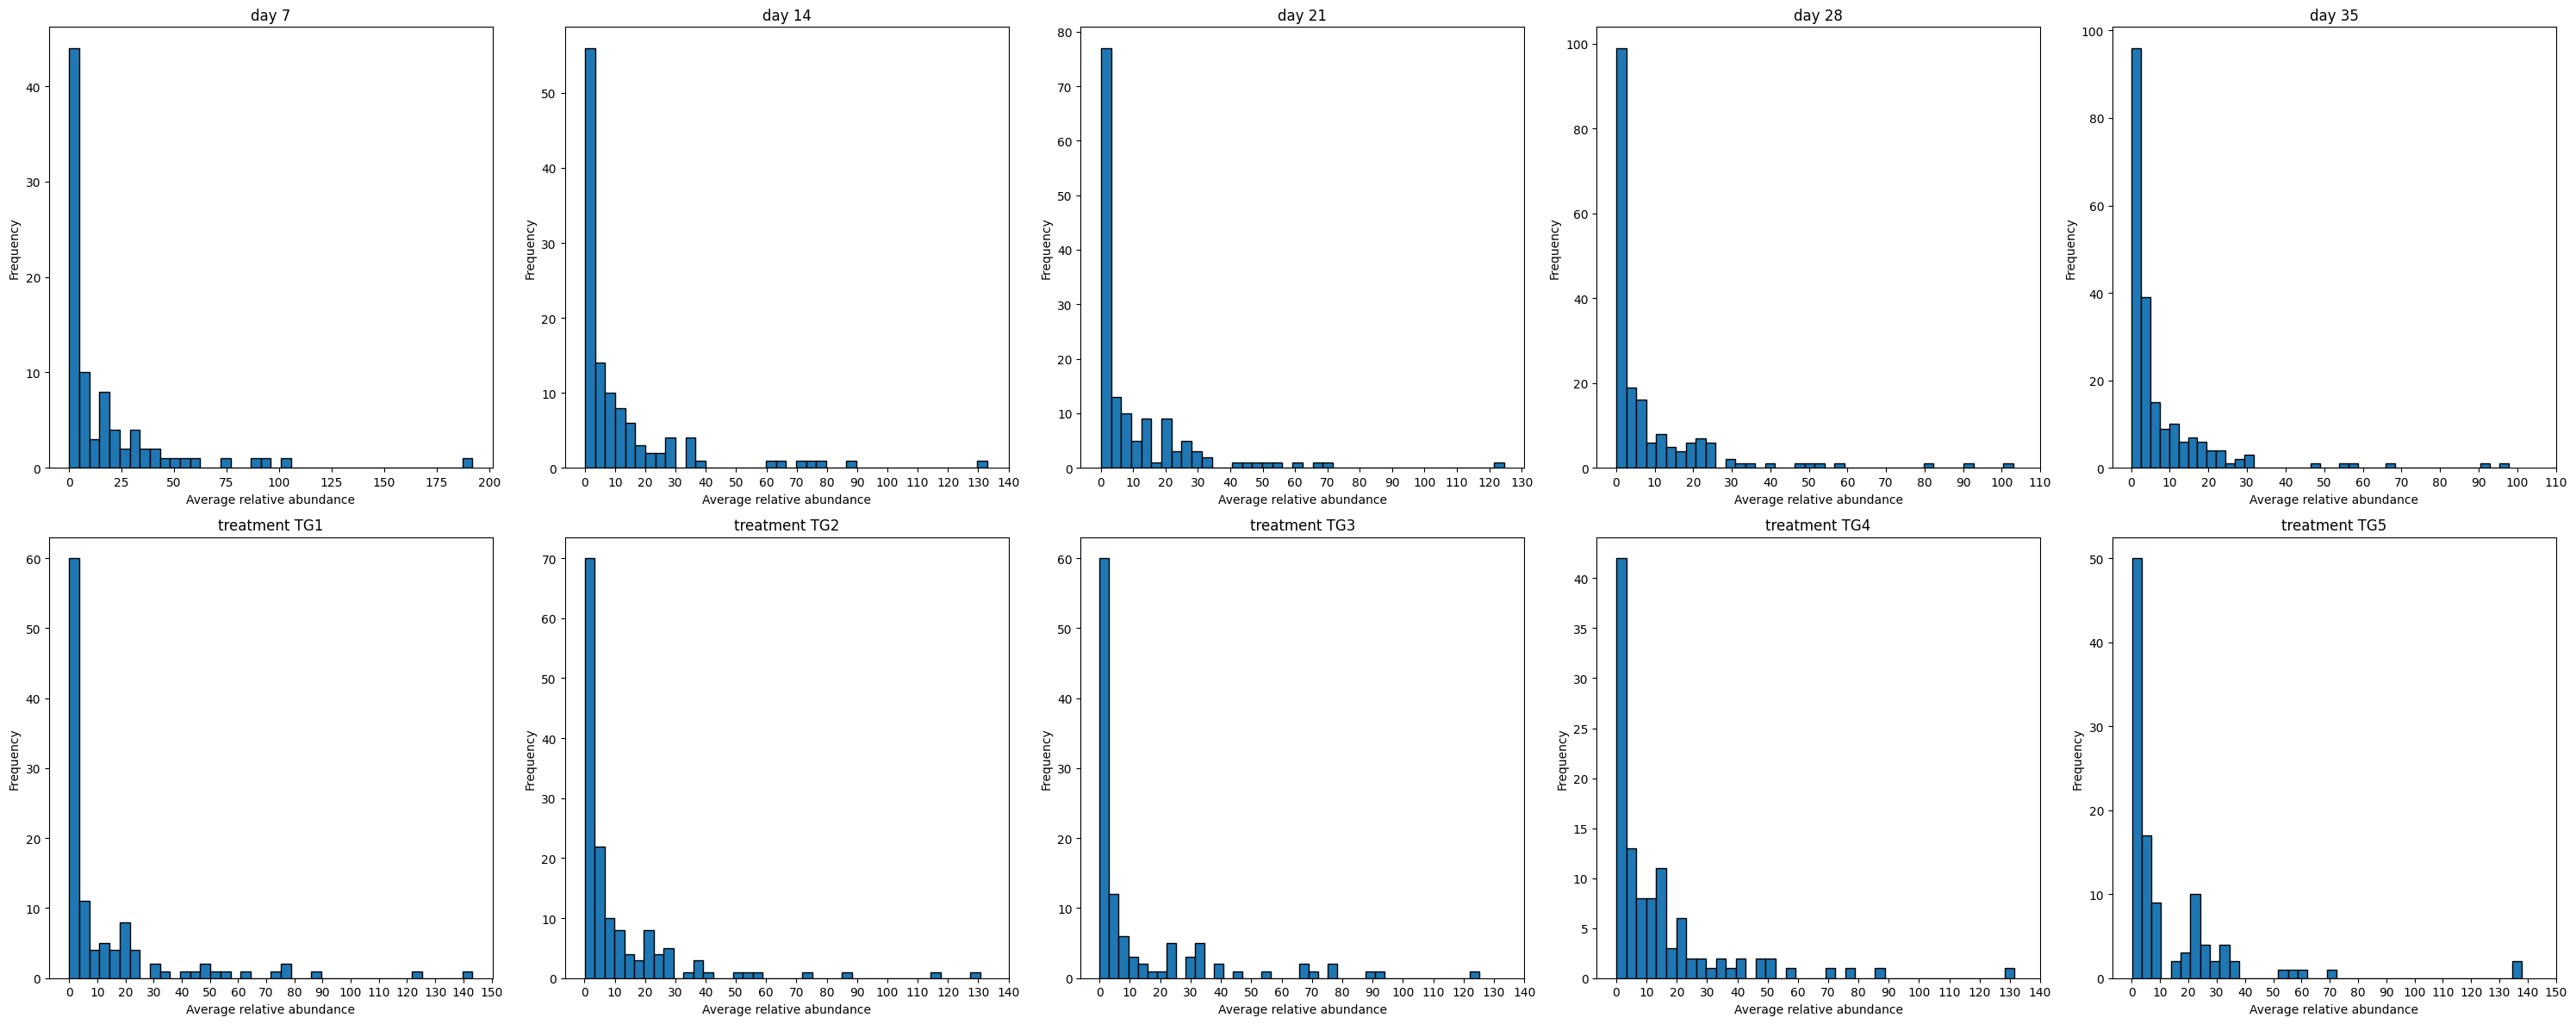

In [60]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(30, 12))  # 5 rows × 2 columns
axes = axes.flatten()   # Flatten to 1D array for easy indexing

plot_idx = 0  # Counter for subplot index

type_case_n_taxa = {}

for type in types:

    type_case_n_taxa[type] = {}

    for case in sorted(metadata.loc[type].unique()):  # Assuming metadata is a DataFrame with `type` as index

        samples  = metadata.columns[metadata.loc[type] == case]
        sub_df   = abd[["genome"] + samples.tolist() + ["classification"]]
        abd_data = sub_df.select_dtypes(include=['number'])

        # Identify numeric columns
        numeric_cols = abd_data.columns

        # Keep only rows where there is at least one non-zero value
        df_cleaned            = sub_df[(abd_data[numeric_cols] != 0).any(axis=1)].copy()
        df_cleaned["average"] = df_cleaned[numeric_cols].mean(axis=1)

        type_case_n_taxa[type][case] = df_cleaned.select_dtypes("number").shape[0]
        
        if plot_idx >= len(axes):
            print(f"Skipping plot {type}-{case}: too many plots for the 5×2 grid.")
            continue

        # Place subplot on the grid
        ax = axes[plot_idx]

        # Main plot
        ax.hist(df_cleaned["average"], bins=40, edgecolor='black')

        # Define tick step
        tick_step = 10
        xmin, xmax = ax.get_xlim()
        if int(xmax) < 200:
            ax.set_xticks(np.arange(0, int(xmax) + tick_step, tick_step))

        ax.set_xlabel("Average relative abundance")
        ax.set_ylabel("Frequency")
        ax.set_title(f"{type} {case}")

        plot_idx += 1

# Hide unused subplots
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])  # or: axes[j].axis('off')


fig.savefig("figs/mean_abundance_per_case.svg", format="svg", dpi=300)

plt.tight_layout()
plt.show()


In [ ]:
df_day   = pd.DataFrame.from_dict(type_case_n_taxa['day'], orient='index', columns=['Sample count'])
df_treat = pd.DataFrame.from_dict(type_case_n_taxa['treatment'], orient='index', columns=['Sample count'])

day_md   = df_day.reset_index().rename(columns={'index': 'Day'}).to_markdown(index=False)
treat_md = df_treat.reset_index().rename(columns={'index': 'Treatment'}).to_markdown(index=False)

display(Markdown(f"### Number of taxa present in the *per day* case\n\n{day_md}"))
display(Markdown(f"### Number of taxa present in the *per treatment* case\n\n{treat_md}"))

### Number of taxa present in the *per day* case

|   Day |   Sample count |
|------:|---------------:|
|     7 |             88 |
|    14 |            117 |
|    21 |            146 |
|    28 |            188 |
|    35 |            208 |

### Number of taxa present in the *per treatment* case

| Treatment   |   Sample count |
|:------------|---------------:|
| TG1         |            112 |
| TG2         |            146 |
| TG3         |            110 |
| TG4         |            110 |
| TG5         |            109 |

You may check for example whether you do have evnn using what we argue we use the following to check the treatment and the day.

### Build input files for `microbetag`

Since we are interested in how communities change per treatment and per day, besides the overall network, we will also build `microbetag`-annotated networks per-day and per-treatment. 

To do so, we need to split the above dataframes accordingly, for each such _type_.

Preavalence threshold to be used 20%.

In [67]:
# Preavalence threshold
threshold = 0.2

First, in the overall case.

In [ ]:
def apply_prev(df, threshold):

    df_tmp = df.copy()

    # Pecentage of nonzero abundance of each genome
    float_cols       = df_tmp.select_dtypes(include='float').columns
    nonzero_fraction = (df_tmp[float_cols] != 0).sum(axis=1) / len(float_cols)

    # Split kept and removed rows
    df_filtered = df_tmp[nonzero_fraction >= threshold]
    df_removed  = df_tmp[nonzero_fraction < threshold]

    # sum of filtered species kept
    sum_row = df_removed[float_cols].sum()
    new_row = {col: 0 for col in df_tmp.columns}
    new_row.update(sum_row.to_dict())
    new_row['classification'] = 'Removed_sum'
    new_row['genome']         = 'Total_removed_abd'

    # Append to filtered DataFrame
    df_filtered = pd.concat([df_filtered, pd.DataFrame([new_row])], ignore_index=True)

    return df_filtered

In [68]:
abd_prev20 = apply_prev(abd, threshold=threshold)

In [70]:
abd.shape, abd_prev20.shape

((223, 113), (94, 113))

In [71]:
abd_prev20.to_csv(microbetag_data / "abundance_prev20.tsv", index=False)

In [ ]:
# if we have fewer correct samples than n -- then do not have a net 
# if we have fewer correct samples than m -- relaxt the filter, with m > n

# Consider removing any edges - nodes to the total-sum 

for type in types:

    # Get the treatment row as a Series
    cases = metadata.loc[type, :]

    for case in cases.unique():
        
        if type == "treatment":
            for i, c in enumerate(case):
                if c.isdigit():
                    ltype, lcase = case[:i], str(case[i:])
                    break
        else:
            lcase = str(case)
            ltype = type

        # Get column names (samples) matching the current treatment
        selected_samples = cases[cases == case].index

        # Subset the metadata to only those samples (i.e., columns)
        tr_metadata = metadata[selected_samples]
        
        # Get same samples from the abundance table
        tr_abd = abd[ ["genome"] + tr_metadata.columns.tolist() + ["classification"]]

        # Pecentage of nonzero abundance of each genome
        float_cols       = tr_abd.select_dtypes(include='float').columns
        nonzero_fraction = (tr_abd[float_cols] != 0).sum(axis=1) / len(float_cols)

        # Split kept and removed rows
        df_filtered = tr_abd[nonzero_fraction >= threshold]
        df_removed  = tr_abd[nonzero_fraction < threshold]

        # sum of filtered species kept
        sum_row = df_removed[float_cols].sum()
        new_row = {col: 0 for col in tr_abd.columns}
        new_row.update(sum_row.to_dict())
        new_row['classification'] = 'Removed_sum'
        new_row['genome'] = 'Total_removed_abd'

        # Append to filtered DataFrame
        df_filtered = pd.concat([df_filtered, pd.DataFrame([new_row])], ignore_index=True)

        # Export those subset of the dataframes to files
        abd_outfile  = "_".join(["abd20", ltype, lcase])
        abd_outfile += ".tsv"
        meta_outfile = "_".join(["metadata20", ltype, lcase])
        meta_outfile += ".tsv"

        df_filtered.to_csv(microbetag_data / "_".join(["per", type]) / abd_outfile, index=False)
        tr_metadata.to_csv(microbetag_data / "_".join(["per", type]) / meta_outfile, index_label="sample", sep="\t")

Cool! 

Now, we are ready to fire `microbetag` !

We will use _microbetag_  `v1.0.4`. To run `microbetag` we need to fill-in a configuration file, which we need to make sure it is the one that corresponds to the _microbetag_ version we'using.

In [ ]:
import yaml 

for type in types:

    input_dir = microbetag_data / "_".join(["per", type])

    # Find all abd_day_*.tsv files
    abd_files = sorted(input_dir.glob("abd20_*.tsv"))

    for abd_file in abd_files:

        # Extract the day number (e.g., 14 from abd_day_14.tsv); .stem is an attribute of a Path object that returns the filename without its suffix (extension).
        case = abd_file.stem.split('_')[-1]

        if type == "treatment":
            ltype = "TG"
            lcase = case.split("TG")[-1]
        else:
            ltype = type
            lcase = str(case)

        # Construct the corresponding metadata filename
        metadata_file = input_dir / f"metadata20_{ltype}_{lcase}.tsv"

        if metadata_file.exists():

            # Open and read the YAML file
            with open(microbetag_data / template_config, 'r') as f:
                config = yaml.safe_load(f)

            config["abundance_table_file"]["file_path"] = str(abd_file)
            config["metadata_file"]["file_path"]        = str(metadata_file)

            # After discussing it with KF, set it as False
            # config["flashweave_args"]["heterogeneous"]["value"] = True

            # In case of day 7 we need to edit FlashWeave's arguments because of low number of samples
            if ltype == "day" and lcase == "7": 
                config["flashweave_args"]["max_k"]["value"] = 2
                config["flashweave_args"]["n_obs_min"]["value"] = 15

        else:
            print(f"Warning: Metadata file for {ltype} {lcase} not found!")

        # Export to YAML file
        conf_file = "_".join(["config", ltype, lcase])
        conf_file += '.yaml'
        with open(conf_file, 'w') as f:
            yaml.dump(config, f, sort_keys=False)

In [ ]:
# Build tarball
!tar -czf reconstructions/GENREs.tar.gz reconstructions/GENREs/
!tar -czf pathway_complementarity.tar.gz pathway_complementarity/

#Decompress tarball 
!tar -zxvf reconstructions/GENREs.tar.gz
!tar -zxvf pathway_complementarity.tar.gz


We now call `microbetag` for each configure file built. 
We have built a bash script for this (`run_mtg.sh`) to avoid notebook-related issues.

>  ⚠️ **ATTENTION!**
>
> GitHub has a max size for a single file at 100MB. Thus the precalculations in some cases are stored as tarballs.
> In case you run this notebook for the first time, make sure you decompress those under the `mgg_prec` output folder.

From a terminal, **activate** the _microbetag_ `conda` environment, and make sure `microbetag` is there: 

In [ ]:
!microbetag -h

Then fire ```bash run_mtg.sh``` - make sure you do so from:

In [ ]:
root 

The `microbetag`-annotated networks will be stored under `microbetag_nets/`

>  ⚠️ **ATTENTION!** Attention !
>
> Only part of the analysis of the _microbetag_-annotated networks will be in this notebook. 
> Another part of the analysis is on the [`06_network_analysis.Rmd`](../06_network_analysis.Rmd). 
>
> However, that part requires the annotated networks to `.cx` format. Thus, before running it, you need to open 
> the _microbetag_ networks we just built with Cytoscape, and export them as `.cx` under the `microbetag_nets/cx/` directory.

## Discussing the nets

### Taxonomy scheme and genome quality

In [25]:
# Load the datasets
genome_taxonomy = pd.read_csv("../data/gtdbtk.summary.tsv", sep="\t")
genome_quality  = pd.read_csv("../data/genomeInfo.csv")

selected_genomes = pd.read_csv("../data/Wdb.csv")
selected_genomes["genome"] = selected_genomes["genome"].str.replace(".fa", "", regex=True)
selected_genomes = selected_genomes["genome"]

# Modify genome names
genome_taxonomy['genome'] = genome_taxonomy['user_genome'].str.replace('.fa', '', regex=True)
genome_taxonomy           = genome_taxonomy[genome_taxonomy['genome'].isin(selected_genomes)]

# Split the classification into separate columns
genome_taxonomy[
    ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    ] = genome_taxonomy['classification'].str.split(';', expand=True)

# Select the relevant columns
genome_taxonomy = genome_taxonomy[
    ['genome', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
]

# Process genome quality data
genome_quality['genome'] = genome_quality['genome'].str.replace('.fa', '', regex=True)

# Filter only selected genomes (the 223 species-representatives)
genome_quality = genome_quality[genome_quality['genome'].isin(selected_genomes)]

# Select relevant columns
genome_quality = genome_quality[['genome', 'completeness', 'contamination', 'length']]

# Merge the two dataframes on the 'genome' column
genome_metadata = pd.merge(genome_taxonomy, genome_quality, on='genome', how='left')

In [30]:
genome_quality.head()

,genome,completeness,contamination,length
1,D300418:bin_000013,81.41,1.94,2332804
118,D300499:bin_000015,95.70,5.45,4069219
150,GPB:bin_000002,100.00,0.41,3812602
151,GPB:bin_000027,94.05,0.03,2666572
152,GPB:bin_000040,99.28,0.18,2134796


In [74]:
genome_taxonomy.head()

,genome,domain,phylum,class,order,family,genus,species
0,D300418:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faeciplasma,s__Faeciplasma gallinarum
12,D300418:bin_000013,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Acutalibacteraceae,g__Fimivicinus,s__Fimivicinus intestinavium
169,D300428:bin_000008,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__Borkfalkiaceae,g__Coproplasma,s__Coproplasma excrementigallinarum
202,D300430:bin_000010,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__Intestinimonas,s__Intestinimonas timonensis
222,D300432:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Lachnospirales,f__Anaerotignaceae,g__Fimicola,s__Fimicola sp944379995


In [75]:
genome_metadata.head()

,genome,domain,phylum,class,order,family,genus,species,completeness,contamination,length
0,D300418:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faeciplasma,s__Faeciplasma gallinarum,99.49,0.17,1791036
1,D300418:bin_000013,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Acutalibacteraceae,g__Fimivicinus,s__Fimivicinus intestinavium,81.41,1.94,2332804
2,D300428:bin_000008,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__Borkfalkiaceae,g__Coproplasma,s__Coproplasma excrementigallinarum,82.32,3.54,1922776
3,D300430:bin_000010,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__Intestinimonas,s__Intestinimonas timonensis,83.60,7.68,3001106
4,D300432:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Lachnospirales,f__Anaerotignaceae,g__Fimicola,s__Fimicola sp944379995,95.93,0.97,2795297


### Overall network

***Salmonella*** is _positively_ associated with **lactic acid**; in agreement with _in vitro_ data. 

It is also _positively_ associated with _Agathobaculum stercoravium_ (family: Butyricicoccaceae). 

I found interesting the subnetworks for TG1 and TG5 where we had a _triange_ of two species having a positive association with the treatment, and a negative association between them! 


In [75]:
genome_metadata

,genome,domain,phylum,class,order,family,genus,species,completeness,contamination,length
0,D300418:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faeciplasma,s__Faeciplasma gallinarum,99.49,0.17,1791036
1,D300418:bin_000013,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Acutalibacteraceae,g__Fimivicinus,s__Fimivicinus intestinavium,81.41,1.94,2332804
2,D300428:bin_000008,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__Borkfalkiaceae,g__Coproplasma,s__Coproplasma excrementigallinarum,82.32,3.54,1922776
3,D300430:bin_000010,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__Intestinimonas,s__Intestinimonas timonensis,83.60,7.68,3001106
4,D300432:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Lachnospirales,f__Anaerotignaceae,g__Fimicola,s__Fimicola sp944379995,95.93,0.97,2795297
...,...,...,...,...,...,...,...,...,...,...,...
218,TG5_28:bin_000003,d__Bacteria,p__Bacillota,c__Bacilli,o__Erysipelotrichales,f__Coprobacillaceae,g__Thomasclavelia,s__Thomasclavelia spiroformis,100.00,0.56,2500811
219,TG5_28:bin_000004,d__Bacteria,p__Bacillota,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__Lactobacillus johnsonii,99.95,0.50,1793304
220,TG5_35:bin_000001,d__Bacteria,p__Bacillota,c__Bacilli,o__Lactobacillales,f__Streptococcaceae,g__Streptococcus,s__Streptococcus alactolyticus,99.99,0.09,1577486
221,TG5_35:bin_000022,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__CAG-74,g__Pullichristensenella,s__Pullichristensenella excrementipullorum,83.77,5.79,2156854


In [76]:
metadata

animal_x,G041,G026,G004,G013,G073,G058,G062,G063,G070,G045,...,G118,G099,G084,G071,G115,G011,G096,G037,G030,G024
sample,,,,,,,,,,,,,,,,,,,,,
treatment,TG2,TG2,TG1,TG1,TG3,TG3,TG3,TG3,TG3,TG2,...,TG5,TG4,TG4,TG3,TG5,TG1,TG4,TG2,TG2,TG1
day,28,7,7,28,35,14,21,21,28,28,...,28,35,14,35,28,21,35,21,14,35
type_simple,P,P,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
L-Asparagine,41717.3822180341,5957.40979346533,4115.37791503571,42407.5366733871,51363.1497354544,12634.5203968611,17431.9401239709,6064.47331125641,38157.8584709551,68670.2036395918,...,44964.1460312401,110969.647290303,121933.871269902,55797.8263877972,41837.4758089825,27343.0337577049,78333.6641326378,19526.5222565585,9066.72707451946,90921.760957879
L-Glutamic acid,4108355.08156706,2287696.48645996,3724094.18178522,3384924.72778087,6066042.22212925,2041074.61850158,1728730.16975281,3100411.74404954,3751145.66650459,2161282.07582736,...,3661020.48278372,7433119.44992929,11295279.1583617,5614728.42434871,3847137.90821618,2172640.03345649,5902004.47467481,2039274.86884451,2813389.16114762,3523988.08099889
Pantothenic acid,30849.8221000725,466217.912693091,779530.896748074,30539.6678355151,55046.2636228555,584338.685942345,115204.941156538,166497.225815491,49462.3547119726,54712.9684317266,...,58268.6277743552,78843.4893557653,732593.301973123,49323.9189762402,38383.9117732477,45409.1431979708,58649.390219574,102312.226268114,426089.029672888,31369.1143654671
L-Alanine,29915.8367929578,66329.3392458584,16081.621975924,34946.6193020637,15379.1662859155,29626.1415912402,34767.8230236641,31058.6192624295,12037.503099832,52107.2957169175,...,15255.1762058102,45103.3534816654,132896.479732957,37010.9481184684,11068.0866797967,28971.8676237773,33510.0969023377,20879.9390902458,18196.9691815351,50771.0010902399
L-Serine,195481.295375394,333276.945045427,100603.168184739,279523.764607492,85776.3956679628,266796.457311849,651753.739818983,252035.428855247,78518.6341061456,221471.940833407,...,211307.462243991,567681.011651232,1274681.647413,976738.027028843,127709.342487101,734691.830820775,221340.207272775,153239.382603606,245467.260197022,232218.065767815
L-Proline,14417076.0802165,30786392.0364292,122048336.33707,16908091.3995128,15921928.2207477,14285254.2555988,13319801.1219875,27003525.1011585,22717565.5986872,13391086.5673492,...,47035728.3063182,18985765.343811,12733222.8009697,32767208.8884666,56346819.4541941,22783080.0337712,16813174.6648037,34990935.0394233,16511455.1473719,16521306.2212459


## Stats

### Prep

Keep track of the non-sequence nodes.

In [15]:
env_var = [
    "treatment_TG1", "treatment_TG2", "treatment_TG3", "treatment_TG4", "treatment_TG5", 
    "day", 
    "salmonella", "synbiotic_water", "synbiotic_feed"
]
metabolites = [
    "L-Tyrosine", "L-Phenylalanine", "L-Tryptophan", "L-Aspartic Acid", "L-Arginine", 
    "L-Leucine", "L-Glutamic acid", "L-Glutamine", "L-Histidine", "L-Lysine", "L-Methionine", 
    "L-Proline", "L-Threonine", "Thiamine", "Adenine", 'Guanosine', "L-Valine" , "L-Alanine", 
    "L-Asparagine", "L-Isoleucine", "L-Serine", "Lactic acid", "Sulfoacetic acid"
]
env_set = set(env_var)
metabolites_set = set(metabolites)

In [16]:
root_dir = Path(os.getcwd())
cx_dir   = root_dir / "microbetag_nets"

In [17]:
cx_overall_filepath = os.path.join(cx_dir, "prev20/overall.cx2")
cx_overall          = load_cx2(cx_overall_filepath)
overall_mtg         = MggParser(cx_overall, env_set, metabolites_set)

### Per day networks

#### Prep

Calculate statistics on the microbetag-annotated networks per day.

Load the `.cx2` files 

In [18]:
cx_07_filepath = os.path.join(cx_dir, "prev20/day07.cx2") ; cx_07 = load_cx2(cx_07_filepath)
cx_14_filepath = os.path.join(cx_dir, "prev20/day14.cx2") ; cx_14 = load_cx2(cx_14_filepath)
cx_21_filepath = os.path.join(cx_dir, "prev20/day21.cx2") ; cx_21 = load_cx2(cx_21_filepath)
cx_28_filepath = os.path.join(cx_dir, "prev20/day28.cx2") ; cx_28 = load_cx2(cx_28_filepath)
cx_35_filepath = os.path.join(cx_dir, "prev20/day35.cx2") ; cx_35 = load_cx2(cx_35_filepath)

Example of how an edge looks like on the `.cx2` format.
```json

// Edge example
    {'id': 245,
    's': 83,
    't': 2,
    'v': {'interaction type': 'cooccurrence',
    'microbetag::weight': 0.9523214101791382,
    'shared name': 'L-Leucine (cooccurss with) L-Isoleucine'}}

```

In [38]:
days = [7, 14, 21, 28, 35]

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [40]:
days_parsed_nets = {
    "day07" : MggParser(cx_07, env_set, metabolites_set),
    "day14" : MggParser(cx_14, env_set, metabolites_set),
    "day21" : MggParser(cx_21, env_set, metabolites_set),
    "day28" : MggParser(cx_28, env_set, metabolites_set),
    "day35" : MggParser(cx_35, env_set, metabolites_set)
}

In [41]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in days_parsed_nets.items()
]
taxon_to_metabo_hits

[0, 8, 12, 11, 13]

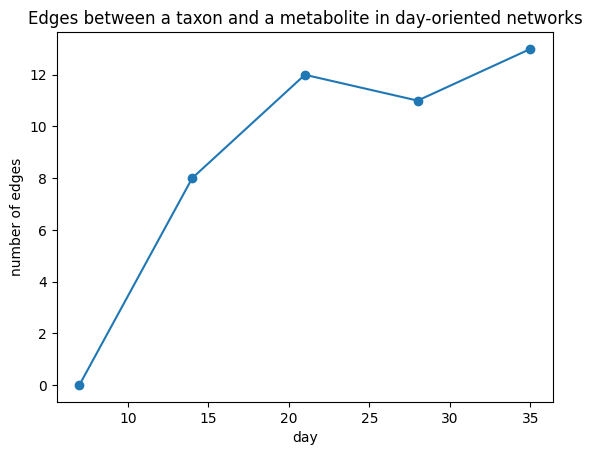

In [42]:
# What to plot
plt.plot(days, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in day-oriented networks")
# Show time
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [43]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in days_parsed_nets.items()
]

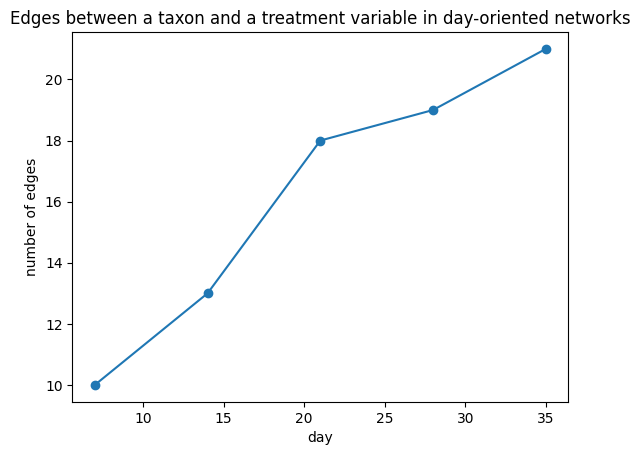

In [44]:
# What to plot
plt.plot(days, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a treatment variable in day-oriented networks")
# Show time
plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [45]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in days_parsed_nets.items()
]

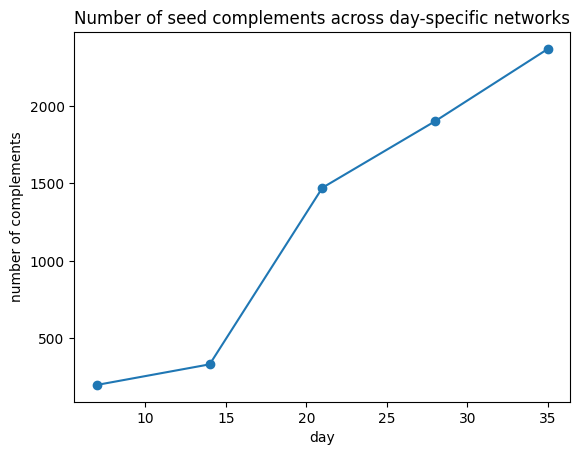

In [46]:
# What to plot
plt.plot(days, overall_number_of_seed_compl, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements across day-specific networks")
# Show time
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [47]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in days_parsed_nets.items()
]

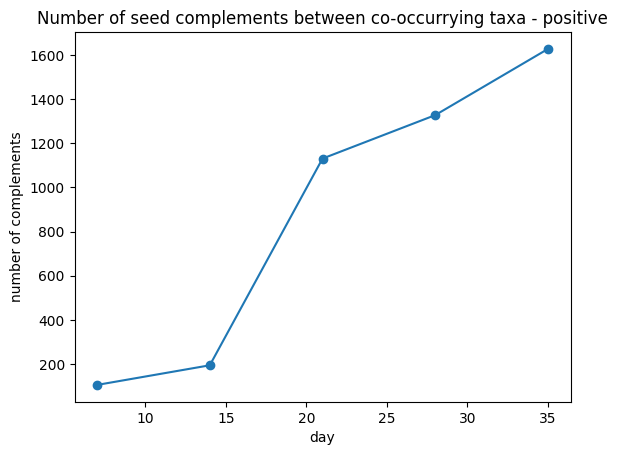

In [48]:
# What to plot
plt.plot(days, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")
# Show time
plt.show()

In [49]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(days_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(days_parsed_nets.values())
]

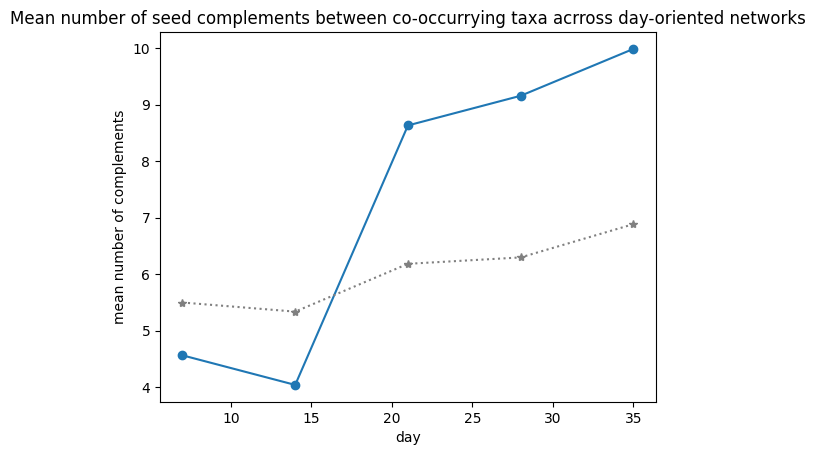

In [50]:
# What to plot
plt.plot(days, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(days, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")
# Labels and title
plt.xlabel("day")
plt.ylabel("mean number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross day-oriented networks")
# Show time
plt.show()

#### Unique compounds involved in potential cross-feedings

In [54]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in days_parsed_nets.items()
]

In [55]:
lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

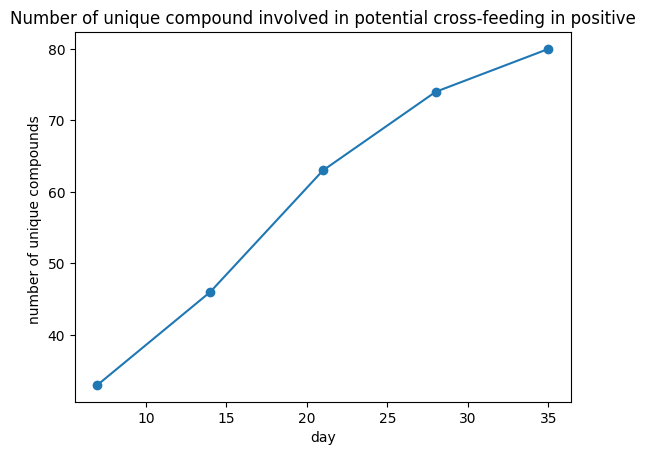

In [56]:
plt.plot(days, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [57]:
day_set = { "day_" + str(i): j for i,j in zip(days, unique_compounds_in_cf_of_positive_associated_taxa)}

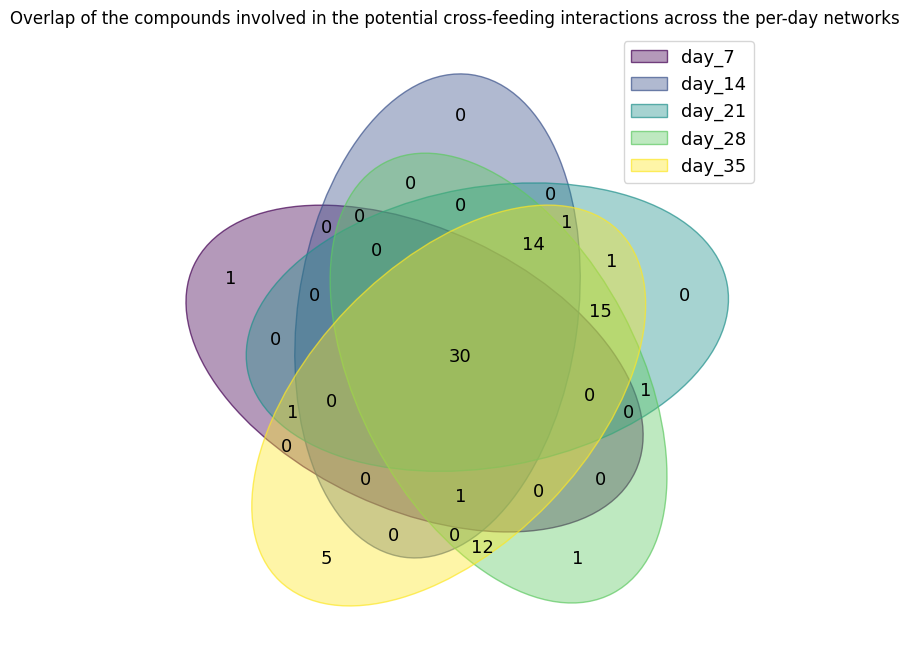

In [58]:
venn(day_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-day networks")

# Show the plot
plt.show()

In [59]:
dfs = {}

ratio_ggplots_wls, ratio_ggplots_ols = [], []

for _, day in enumerate(days_parsed_nets):                      # # NOTE (Haris Zafeiropoulos, 2025-04-02):  Enumerate will keep the same order as long as we do not edit the days_parased_nets dictionary

    day_net = days_parsed_nets[day]

    df = process_cooccurrence_and_regression(
        day_net, day, metabolites, env_set
    )

    dfs[day] = df


for day, df in dfs.items():

        ratio_ggplots_wls.append( plot_neighbors_per_seed_compl(df, day,  model="WLS") )  # or OLS
        ratio_ggplots_ols.append( plot_neighbors_per_seed_compl(df, day,  model="OLS") )

In [60]:
day_w_pearson = {}
day_spearman  = {}

for day, df in dfs.items():

    r2, p_v = weighted_pearson_with_pvalue(df, "neighbors_num", "compl_ratio", "compl_ratio")
    day_w_pearson[day] = {}
    day_w_pearson[day]["r^2"]    = r2
    day_w_pearson[day]["pvalue"] = p_v

    day_spearman[day] = spearman_corr(df, "neighbors_num", "compl_ratio")


/home/luna.kuleuven.be/u0156635/github_repos/contribute-to/AMAC005_chicken_salmonella/microbetag_analysis/stats.py:141: RuntimeWarning: invalid value encountered in scalar divide
/home/luna.kuleuven.be/u0156635/github_repos/contribute-to/AMAC005_chicken_salmonella/microbetag_analysis/stats.py:165: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


In [61]:
pd.DataFrame.from_dict(day_spearman, orient="index", columns=["Spearman"])

,Spearman
day07,NaN
day14,0.033835
day21,0.070317
day28,0.053564
day35,0.043343


In the `ratio_ggplots_ols`, we now have for each day net its corresponding plot:

In [62]:
COMPLEMENTS_NUMBER

'seed_compls_num'

In [63]:
from plotnine import stat_smooth
from scipy.stats import linregress
import statsmodels.formula.api as smf

for day, case in zip(days, ratio_ggplots_wls):

    adf = case[1]
    adf["genome_size"] = adf["name"].map(genome_metadata.set_index("genome")["length"])
    adf["compls_per_neighbor"] = adf[COMPLEMENTS_NUMBER] / adf[NEIGHBORS_NUMBER]

    x = adf[NEIGHBORS_NUMBER]
    # y = adf[COMPLEMENTS_NUMBER]
    y = adf["compls_per_neighbor"]

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    model = smf.quantreg(f"{COMPLEMENTS_NUMBER} ~ {NEIGHBORS_NUMBER}", adf)
    res = model.fit(q=0.5)
    # Median regression coefficient for neighbors_num
    slope = res.params[NEIGHBORS_NUMBER]

    # Intercept
    intercept = res.params['Intercept']

    # p-value for the slope
    pval = res.pvalues[NEIGHBORS_NUMBER]

    # Pseudo R²
    pseudo_r2 = res.prsquared  # or res.rsquared if available# median regression
    print(res.summary())


    p = (
        ggplot(adf, aes(
            x     = NEIGHBORS_NUMBER,
            # y     = COMPLEMENTS_NUMBER,
            y = "compls_per_neighbor",
            color = 'order',              # assuming 'order' is a column
            size  = 'genome_size'         # map genome_size to point size
        ))
        + geom_point()
        + stat_smooth(method='lm', se=True, color='black')  # regression line
        + labs(
            color = 'Order',
            size  = 'Genome Size'
        )
        + theme_minimal()

        + labs(
        title = f"day {day} at the order level",
        x     = "Neighbors Number",
        # y     = "Seed Complements Number",
        y     = "Seed Complements per Neighbor",
        )
        + annotate(
            "text",
            x = adf[NEIGHBORS_NUMBER].max() * 0.8,
            y = adf["compls_per_neighbor"].max() * 0.9,
            label = f"Intercept = {intercept:.2f}\nSlope = {slope:.2f}\nPseudo R² = {pseudo_r2:.3f}\nP-value = {pval:.3g}",
            size = 10,
            color = "black",
        )

        # + annotate(
        #     "text",
        #     x     = adf[NEIGHBORS_NUMBER].max() * 0.8,
        #     y     = adf[RATIO].max() * 0.9,
        #     label = f"R² = {r_value:.3f}\nP-value = {p_value:.3g}",
        #     size  = 10,
        #     color = "black",
        # )
    )

    ggsave(
        p,
        filename = f"figs/seed_stats/day{day}_family_wls.png",
        dpi      = 300,
        width    = 8,
        height   = 6
    )


ValueError: Cannot calculate a linear regression if all x values are identical

To save all the per day plots with the seed complementarities number against the number of positive neighbors:

In [106]:
df = process_cooccurrence_and_regression(
        overall_mtg, "overall", metabolites, env_set
    )
df.head()

,id,neighbors_num,neighbors,seed_compls_num,name,species,family,order,condition,compl_ratio
5,5,3,"{113, 2, 44}",27,D300452:bin_000016,s__Eisenbergiella sp904392525,f__Lachnospiraceae,o__Lachnospirales,overall,9.00
2,2,2,"{34, 5}",10,D300435:bin_000001,s__Anaerotignum merdipullorum,f__Anaerotignaceae,o__Lachnospirales,overall,5.00
10,10,2,"{4, 60}",10,D300479:bin_000005,s__Ornithomonoglobus merdipullorum,f__UBA1381,o__UBA1381,overall,5.00
4,4,4,"{16, 17, 10, 66}",21,D300444:bin_000010,s__Enterocloster excrementigallinarum,f__Lachnospiraceae,o__Lachnospirales,overall,5.25
1,1,2,"{3, 39}",26,D300430:bin_000010,s__Intestinimonas timonensis,f__Oscillospiraceae,o__Oscillospirales,overall,13.00


In [107]:
overall = plot_neighbors_per_seed_compl(df, "overall")
overall[1].head()

,id,neighbors_num,neighbors,seed_compls_num,name,species,family,order,condition,compl_ratio
5,5,3,"{113, 2, 44}",27,D300452:bin_000016,s__Eisenbergiella sp904392525,f__Lachnospiraceae,o__Lachnospirales,overall,9.00
2,2,2,"{34, 5}",10,D300435:bin_000001,s__Anaerotignum merdipullorum,f__Anaerotignaceae,o__Lachnospirales,overall,5.00
10,10,2,"{4, 60}",10,D300479:bin_000005,s__Ornithomonoglobus merdipullorum,f__UBA1381,o__UBA1381,overall,5.00
4,4,4,"{16, 17, 10, 66}",21,D300444:bin_000010,s__Enterocloster excrementigallinarum,f__Lachnospiraceae,o__Lachnospirales,overall,5.25
1,1,2,"{3, 39}",26,D300430:bin_000010,s__Intestinimonas timonensis,f__Oscillospiraceae,o__Oscillospirales,overall,13.00


Use the genome metadata `df` we built in the beginning of the notebook, to get the genome size of each MAG.

In [108]:
for df in dfs.values():
    df["genome size"] = df["name"].map(genome_metadata.set_index("genome")["length"])
    df.rename(columns={"neighbors_num": "number of neighbors", "compl_ratio": "seed complements per neighbor"}, inplace=True)
df.head()

,id,number of neighbors,neighbors,seed_compls_num,name,species,family,order,condition,seed complements per neighbor,genome_size,compls_per_neighbor,genome size
2,2,1,{3},20,D300430:bin_000010,s__Intestinimonas timonensis,f__Oscillospiraceae,o__Oscillospirales,day35,20.000000,3001106,20.000000,3001106
3,3,2,"{2, 50}",35,D300435:bin_000001,s__Anaerotignum merdipullorum,f__Anaerotignaceae,o__Lachnospirales,day35,17.500000,2545646,17.500000,2545646
20,20,1,{19},9,D300499:bin_000015,s__Caccovicinus sp017889125,f__Lachnospiraceae,o__Lachnospirales,day35,9.000000,4069219,9.000000,4069219
19,19,3,"{40, 170, 20}",34,D300493:bin_000002,s__Fimenecus stercoravium,f__Acutalibacteraceae,o__Oscillospirales,day35,11.333333,2043415,11.333333,2043415
21,21,3,"{9, 5, 157}",45,D300500:bin_000011,s__Gemmiger stercoravium,f__Ruminococcaceae,o__Oscillospirales,day35,15.000000,1691313,15.000000,1691313


In [110]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df, 
    x        = 'number of neighbors',
    y        = 'seed complements per neighbor',
    z        = 'genome size',
    color    = 'order',
    symbol   = 'order',
    size_max = 10,
    opacity  = 0.8
)

In [111]:
# Save the plot as an HTML file
html_file = "plotly_3d_plot2.html"
fig.write_html(html_file)

# Open the HTML file in the default web browser
webbrowser.open(html_file)

True

/home/luna.kuleuven.be/u0156635/github_repos/contribute-to/AMAC005_chicken_salmonella/microbetag_analysis/plotly_3d_plot2.html:1
<html>
^

SyntaxError: Unexpected token '<'
    at wrapSafe (node:internal/modules/cjs/loader:1385:20)
    at Module._compile (node:internal/modules/cjs/loader:1435:41)
    at Module._extensions..js (node:internal/modules/cjs/loader:1564:10)
    at Module.load (node:internal/modules/cjs/loader:1295:32)
    at Module._load (node:internal/modules/cjs/loader:1111:12)
    at c._load (node:electron/js2c/node_init:2:16955)
    at Function.executeUserEntryPoint [as runMain] (node:internal/modules/run_main:188:12)
    at node:internal/main/run_main_module:28:49

Node.js v20.18.2


After I open the `.html` file on my browser, I turned it around a bit and I extracted its ***camera settings*** by moving to the *Inspect* and running the following command on the `Console`:


    JSON.stringify(document.querySelector("div.js-plotly-plot")._fullLayout.scene.camera)


In [ ]:
camera_settings = {
    "up"        : {"x":0,"y":0,"z":1},
    "center"    : {"x":0,"y":0,"z":0},
    "eye"       : {"x":-1.0142173958395229,"y":1.6792529527047904,"z":0.9159544720174357},
    "projection": {"type":"perspective"}
}

In [ ]:
fig.update_layout(
    scene_camera     = camera_settings,
    width            = 1200,               # Width of the figure in pixels
    height           = 1000,               # Height of the figure in pixels
    plot_bgcolor     = 'rgba(0, 0, 0, 0)', # Transparent background for the plot area
    paper_bgcolor    = 'rgba(0, 0, 0, 0)', # Transparent background for the surrounding area
    font             = dict(size=14),      # Increase font size for axes and other text elements
    title_font       = {"size": 40},
    yaxis_title_font = dict(size=20)   # Increase font size for y-axis label
)

fig.update_xaxes(title='New x label')

# Save the figure as an SVG file
pio.write_image(fig, "plot.svg")

In [64]:
# cx_07
# days_parsed_nets["day07"].edge_types.keys()

taxa_pair_2_edge_id = {}
for edge_id in cx_07.get_edges():
    edge = cx_07.get_edge(edge_id)    
    pair = (edge["s"], edge["t"])
    if edge["v"]["interaction type"] != COMPL_INT_TYPE:
        taxa_pair_2_edge_id[pair] = edge_id


pos_weight_scores, neg_weight_scores = {}, {}

for edge_id in days_parsed_nets["day07"].edge_types["taxon_to_taxon"]["edges"]:
    edge = cx_07.get_edge(edge_id)

    if edge["v"]["interaction type"] in [COOCCURENCE, COEXCLUSION]:
        continue

    try:
        comp, coop, s, t = edge["v"][SEED_COMP], edge["v"][SEED_COOP], edge["s"], edge["t"]
    except Exception as e:
        print(f"Warning: {e} not found in edge {edge["v"].keys()}")
        continue

    eid = taxa_pair_2_edge_id.get((s, t), taxa_pair_2_edge_id.get((t, s)))

    fw_score = cx_07.get_edge(eid)["v"]["microbetag::weight"]
    target = pos_weight_scores if fw_score > 0 else neg_weight_scores
    
    target[edge_id] = {COOPERATION: coop, COMPETITION: comp}
    
    if fw_score > 0:
        target[edge_id][COOCCURENCE] = fw_score
    else:
        target[edge_id][COEXCLUSION] = fw_score


In [ ]:
df = pd.DataFrame.from_dict(pos_weight_scores, orient="index")
df.head()

,cooperation,competition,co-occurrence
32,0.11,0.53,0.860448
33,0.28,0.59,0.860448
34,0.02,0.86,0.979926
35,0.10,0.87,0.979926
38,0.13,0.56,0.647934


In [66]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df[COOPERATION], df[COOCCURENCE])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df[COOPERATION], df[COOCCURENCE])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.09985262677618476
Spearman correlation: -0.32828409256527924


In [67]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df[COMPETITION], df[COOCCURENCE])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df[COMPETITION], df[COOCCURENCE])
print("Spearman correlation:", spearman_corr)

Pearson correlation: 0.3195864283445205
Spearman correlation: 0.5317466205035108


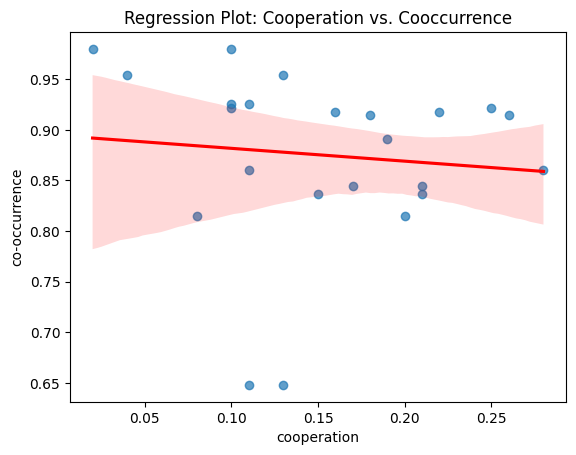

In [68]:
sns.regplot(
    x           = df[COOPERATION],
    y           = df[COOCCURENCE],
    scatter_kws = {"alpha": 0.7},
    line_kws    = {"color": "red"}
)
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [69]:
from scipy.stats import pearsonr, spearmanr
df = pd.DataFrame.from_dict(neg_weight_scores, orient="index")
df = df.astype(float) 
df.head()

pearson_corr, _ = pearsonr(df[COOPERATION], df[COEXCLUSION])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df[COOPERATION], df[COEXCLUSION])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.12077746655925412
Spearman correlation: -0.1592178770949721


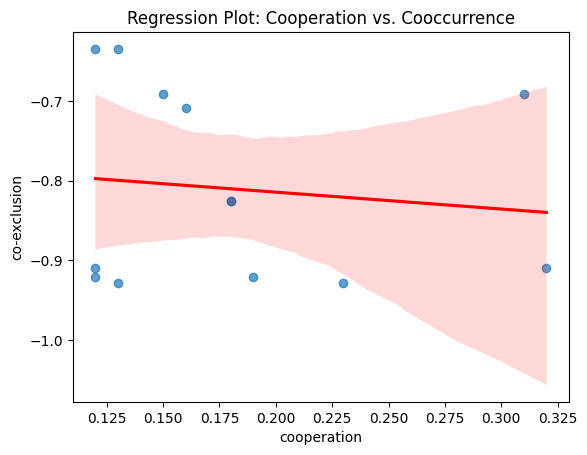

In [70]:
sns.regplot(
    x           = df[COOPERATION],
    y           = df[COEXCLUSION],
    scatter_kws = {"alpha": 0.7},
    line_kws    = {"color": "red"}
)
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

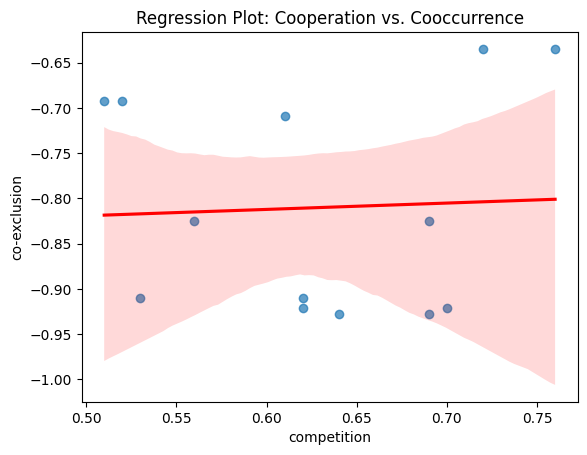

In [71]:
sns.regplot(
    x           = df[COMPETITION],
    y           = df[COEXCLUSION],
    scatter_kws = {"alpha": 0.7},
    line_kws    = {"color": "red"}
)
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [120]:
day_cx_objects = {
    "day07": cx_07,
    "day14": cx_14,
    "day21": cx_21,
    "day28": cx_28,
    "day35": cx_35
}

all_scores = {
    day: compute_weight_scores(cx_net, days_parsed_nets[day])
    for day, cx_net in day_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::c

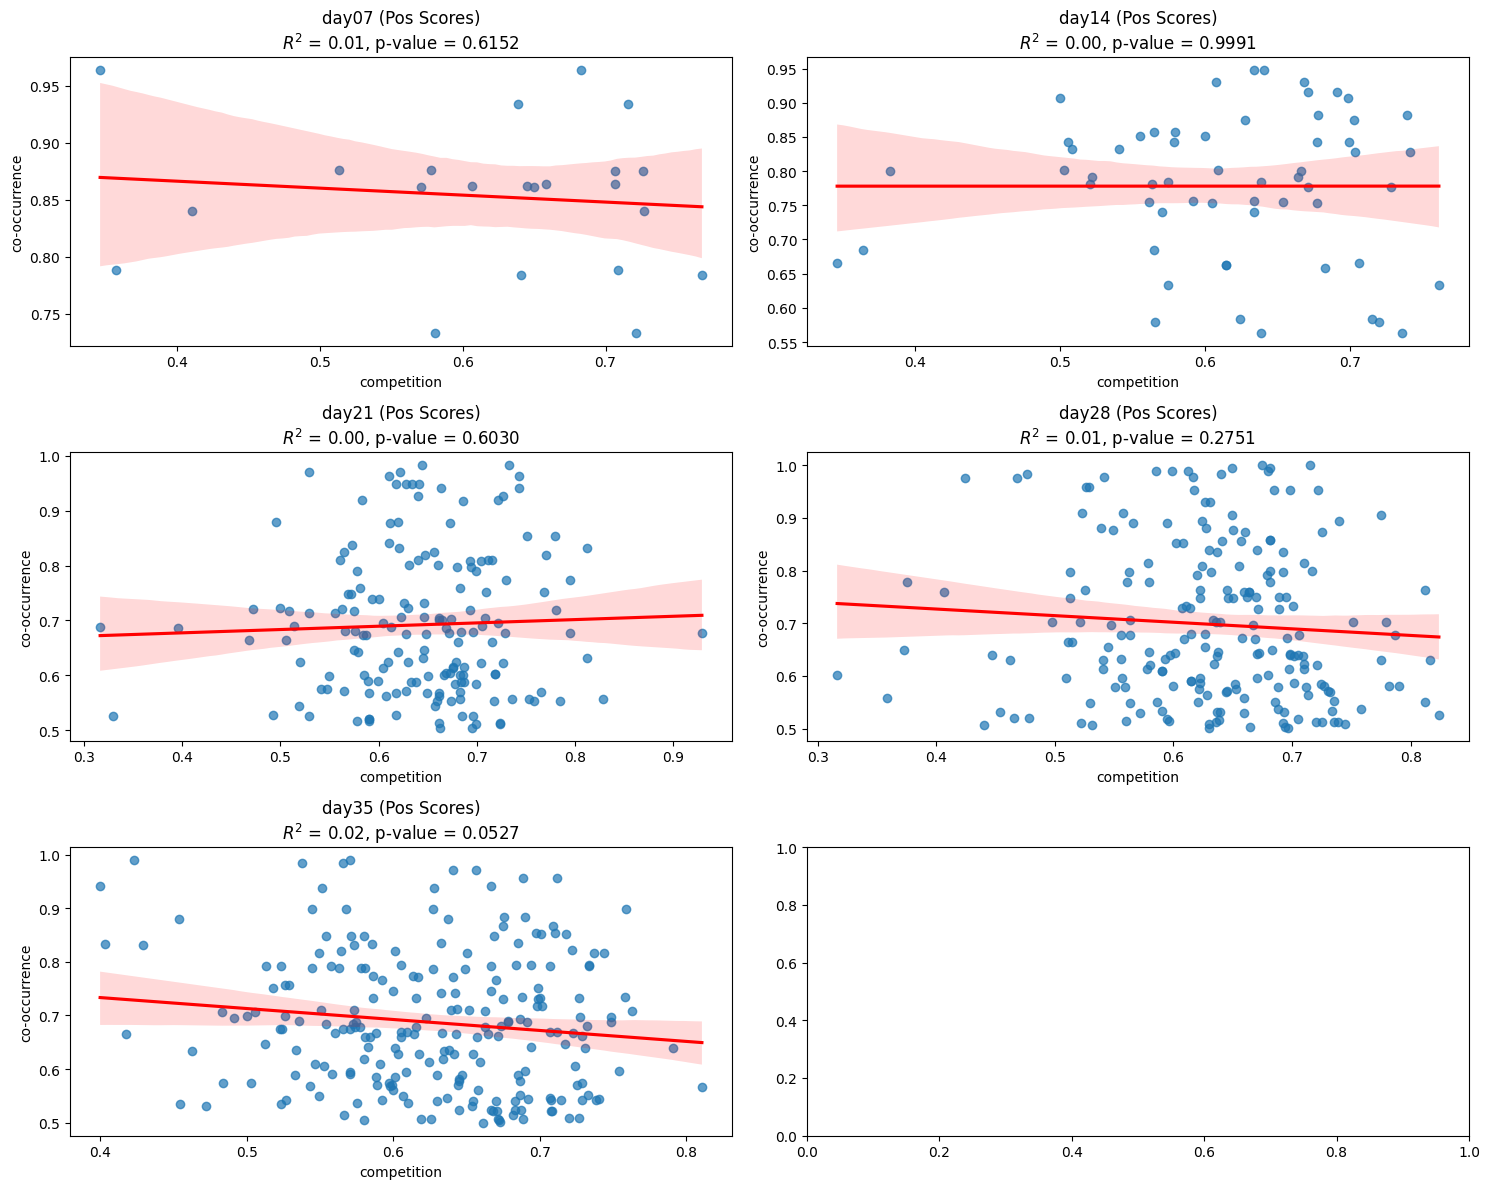

In [121]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not pos_df.empty:  # Plot positive weight scores
        plot_regression(axes[i], pos_df, COMPETITION, COOCCURENCE, f"{day} (Pos Scores)")
        # plot_regression(axes[i], pos_df, COOPERATION, COOCCURENCE, f"{day} (Pos Scores)")
        # plot_dual_regression(axes[i], pos_df, COOCCURENCE, COOPERATION, COMPETITION, f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

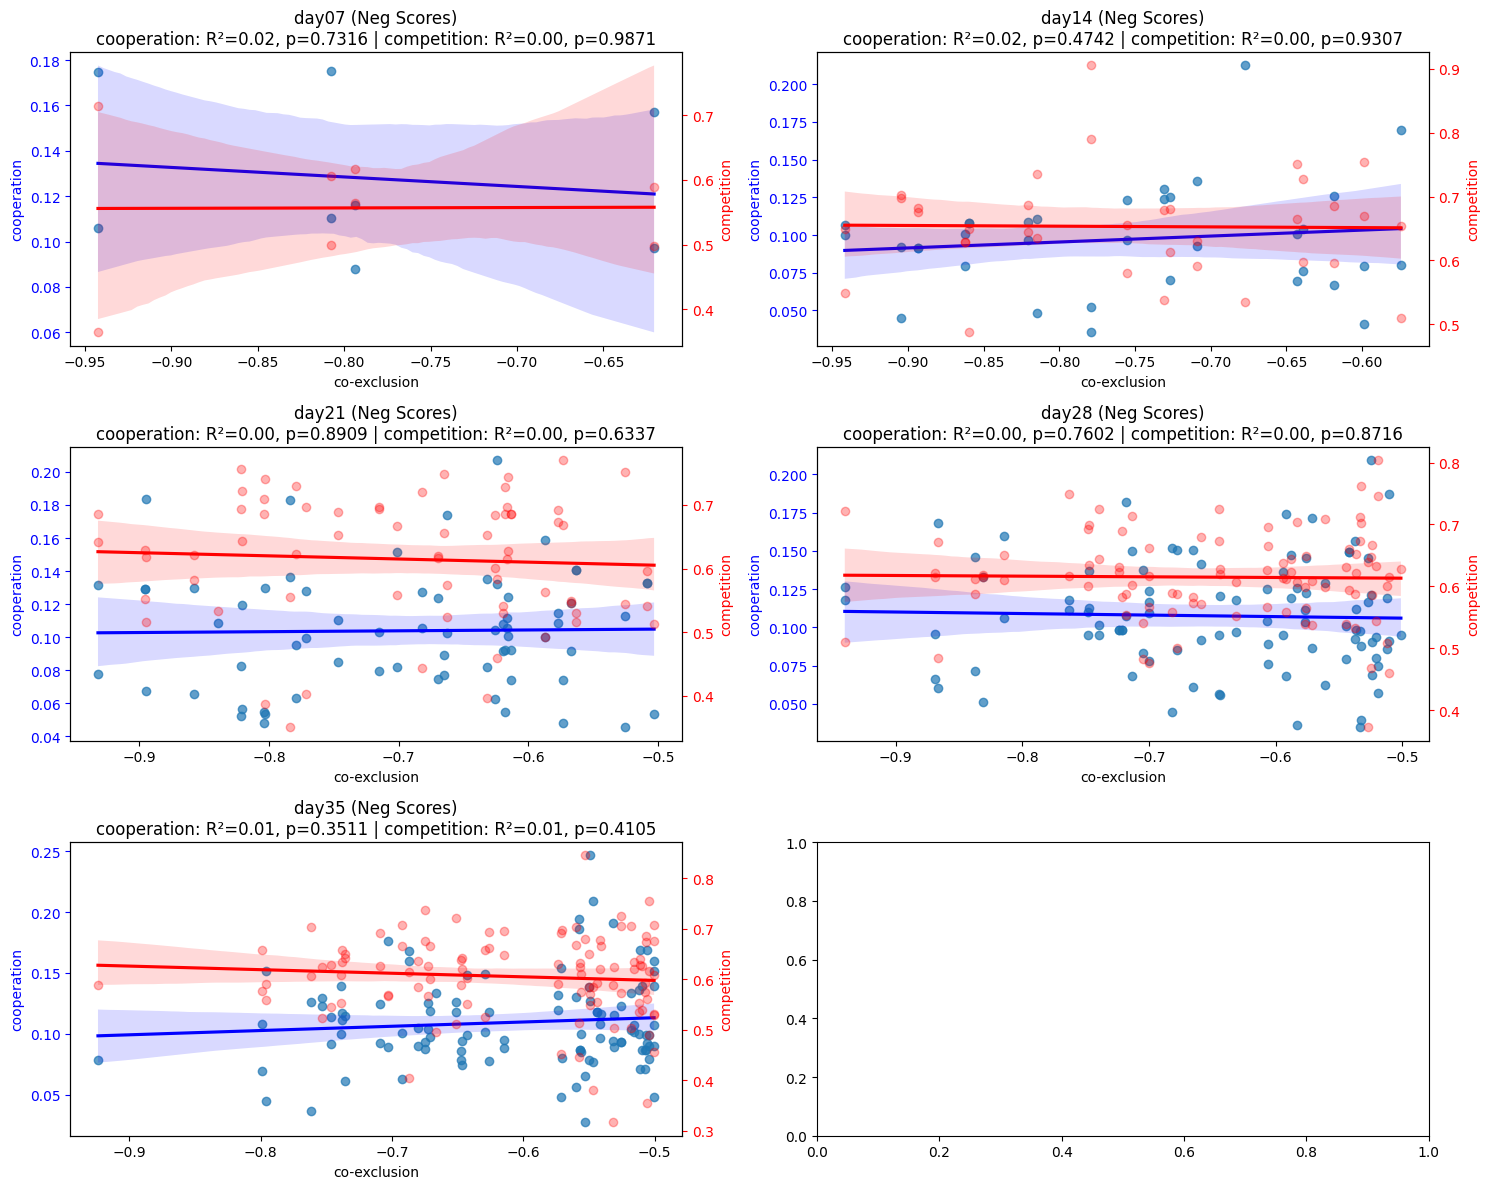

In [122]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
 
    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, COMPETITION, COEXCLUSION, f"{day} (Neg Scores)")
            # plot_regression(axes[i + 1], neg_df, COOPERATION, COEXCLUSION, f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, COEXCLUSION, COOPERATION, COMPETITION, f"{day} (Neg Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Per treatment

#### Prep

In [19]:
cx_tg1_filepath = os.path.join(cx_dir, "prev20/TG1.cx2") ; cx_tg_1 = load_cx2(cx_tg1_filepath)
cx_tg2_filepath = os.path.join(cx_dir, "prev20/TG2.cx2") ; cx_tg_2 = load_cx2(cx_tg2_filepath)
cx_tg3_filepath = os.path.join(cx_dir, "prev20/TG3.cx2") ; cx_tg_3 = load_cx2(cx_tg3_filepath)
cx_tg4_filepath = os.path.join(cx_dir, "prev20/TG4.cx2") ; cx_tg_4 = load_cx2(cx_tg4_filepath)
cx_tg5_filepath = os.path.join(cx_dir, "prev20/TG5.cx2") ; cx_tg_5 = load_cx2(cx_tg5_filepath)

In [73]:
treatment_parsed_nets = {
    "TG_1" : MggParser(cx_tg_1, env_set, metabolites_set),
    "TG_2" : MggParser(cx_tg_2, env_set, metabolites_set),
    "TG_3" : MggParser(cx_tg_3, env_set, metabolites_set),
    "TG_4" : MggParser(cx_tg_4, env_set, metabolites_set),
    "TG_5" : MggParser(cx_tg_5, env_set, metabolites_set)
}

In [74]:
treatment_cx_objects = {
    "TG_1": cx_tg_1,
    "TG_2": cx_tg_2,
    "TG_3": cx_tg_3,
    "TG_4": cx_tg_4,
    "TG_5": cx_tg_5
}

In [75]:
all_scores_treatments = {
    treatment: compute_weight_scores(cx_net, treatment_parsed_nets[treatment])
    for treatment, cx_net in treatment_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::c

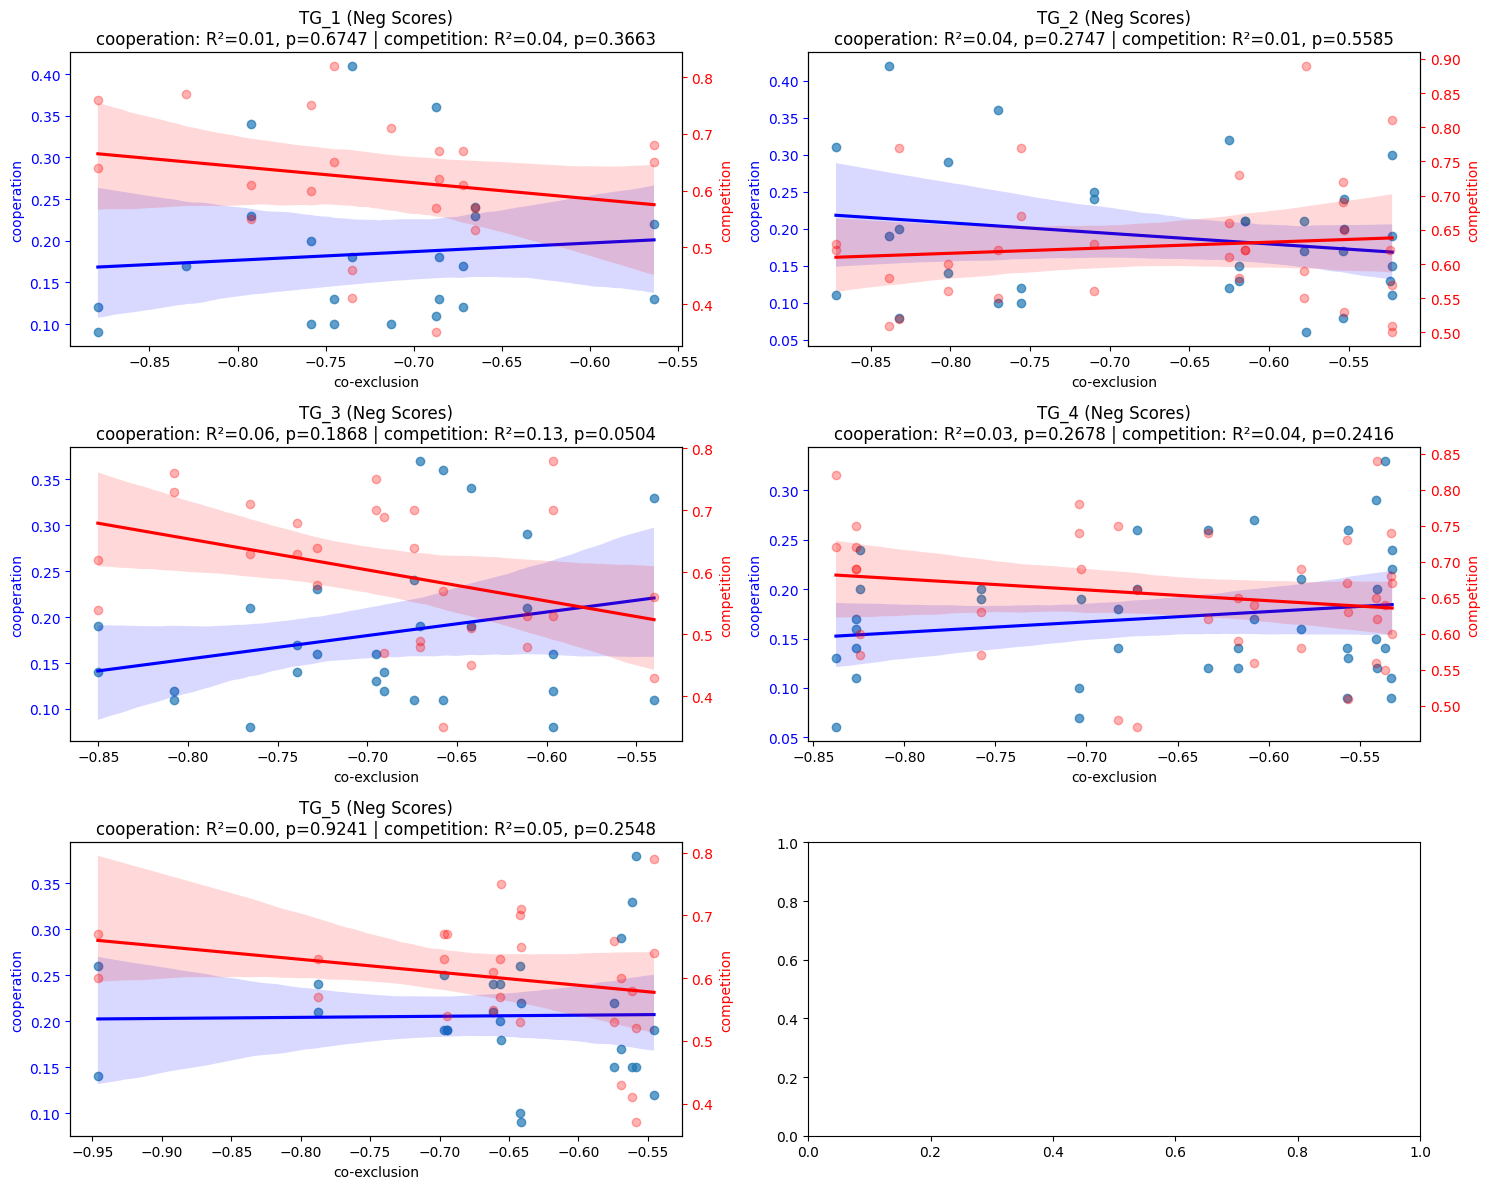

In [76]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  

axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (treatment, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df     = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df     = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            plot_dual_regression(axes[i], neg_df, COEXCLUSION, COOPERATION, COMPETITION, f"{treatment} (Neg Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

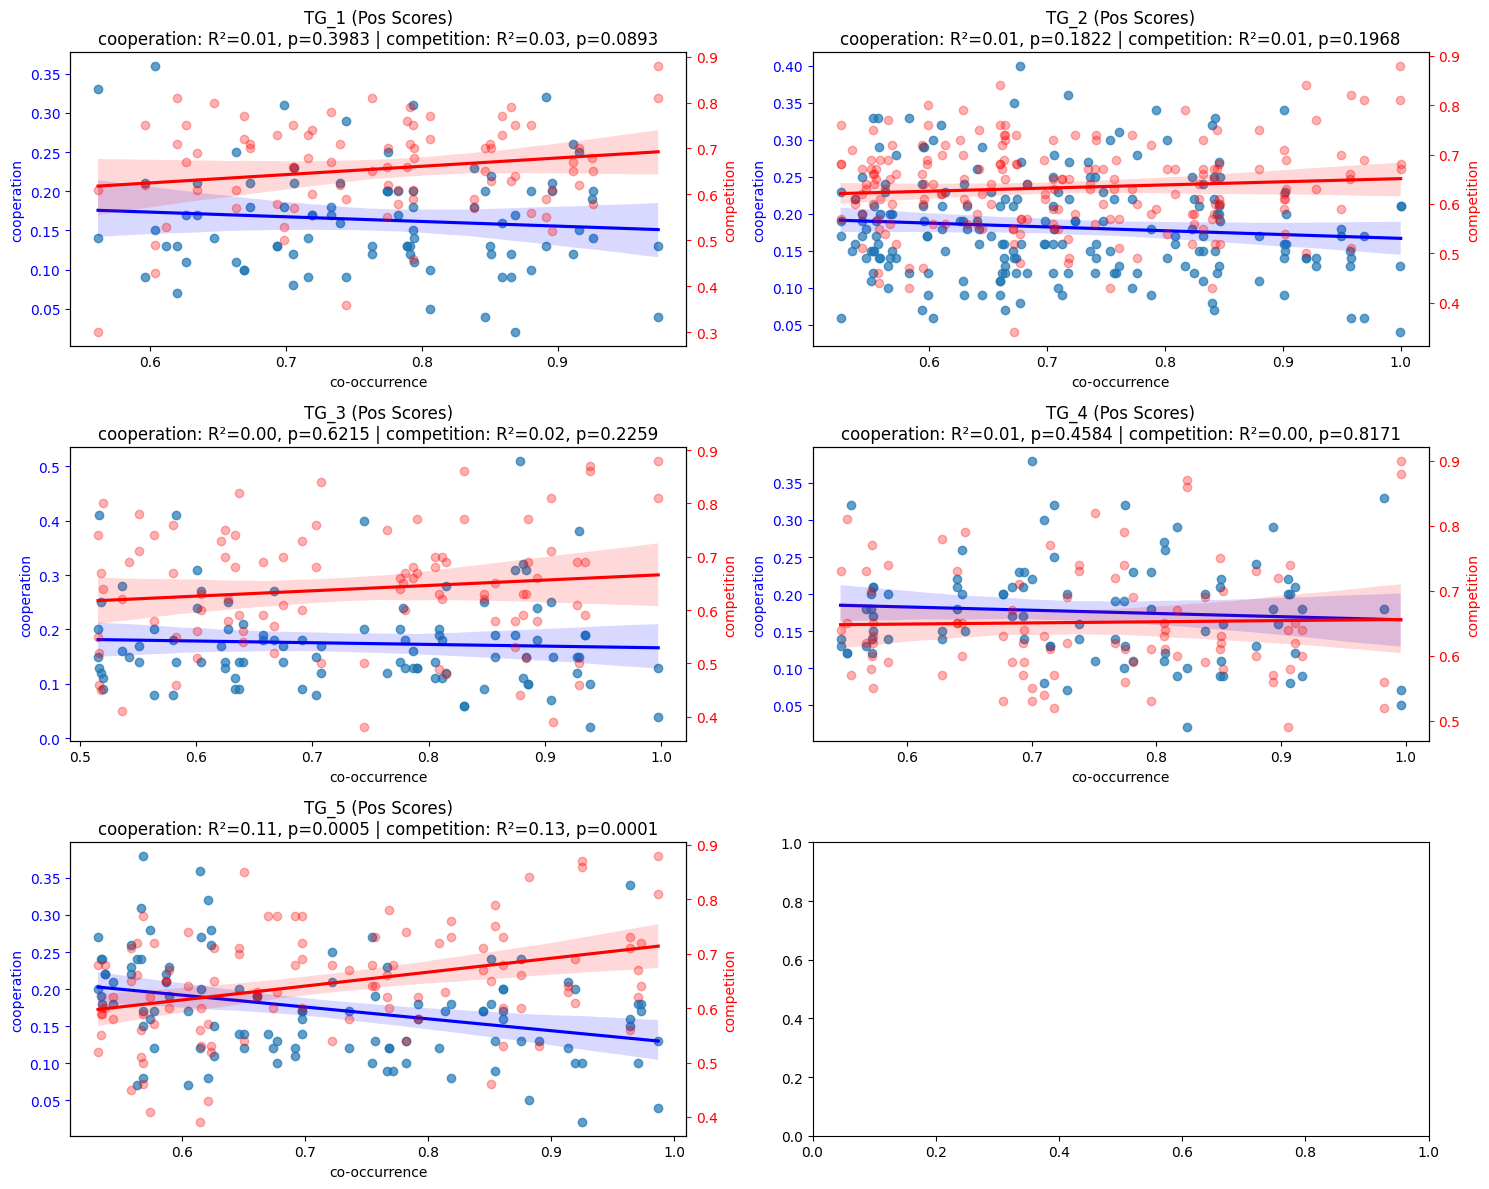

In [77]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (treatment, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break
    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    if not pos_df.empty:  # Plot positive weight scores
        # plot_regression(axes[i], pos_df, COOPERATION, COOCCURENCE, f"{day} (Pos Scores)")
        plot_dual_regression(axes[i], pos_df, COOCCURENCE, COOPERATION, COMPETITION, f"{treatment} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [78]:
tg_microbetag_nets = [cx_tg_1, cx_tg_2, cx_tg_3, cx_tg_4, cx_tg_5]
treatments = ["TG1", "TG2", "TG3", "TG4", "TG5"]
treatments_descr = [
    "TG1:Salmonella, synbiont both water and feed",
    "TG2:Salmonella, synbiont in water",
    "TG3:Salmonella, synbiont in feed",
    "TG4:Salmonella, no symbiont",
    "TG5:No Salmonella, no symbiont"
]

In [79]:
parsed_tg_edges = []
for tg_mgg_net in tg_microbetag_nets:
    num_compl, types, pos_pairs, compounds = parse_microbetag_edges(tg_mgg_net, env_set=env_set, metabolites_set=metabolites_set)
    parsed_tg_edges.append([num_compl, types, pos_pairs, compounds])

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [ ]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in treatment_parsed_nets.items()
]

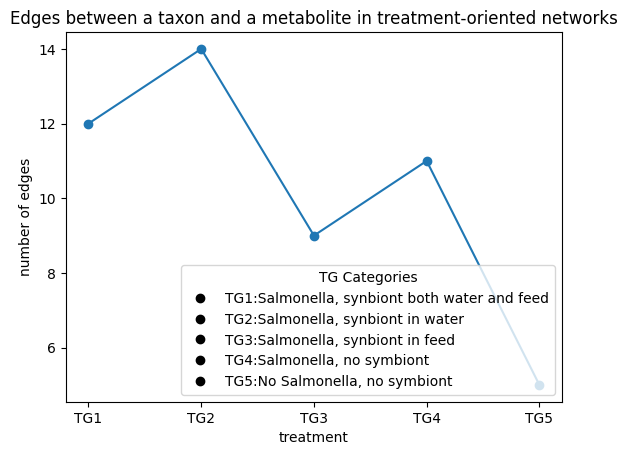

In [81]:
plt.plot(treatments, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in treatment-oriented networks")
# Create proxy artists for legend
legend_handles = [mlines.Line2D([], [], color='black', marker='o', linestyle='None', label=t) for t in treatments_descr]
# Add legend box
plt.legend(handles=legend_handles, title="TG Categories", loc="lower right", frameon=True)
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [85]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in treatment_parsed_nets.items()
]

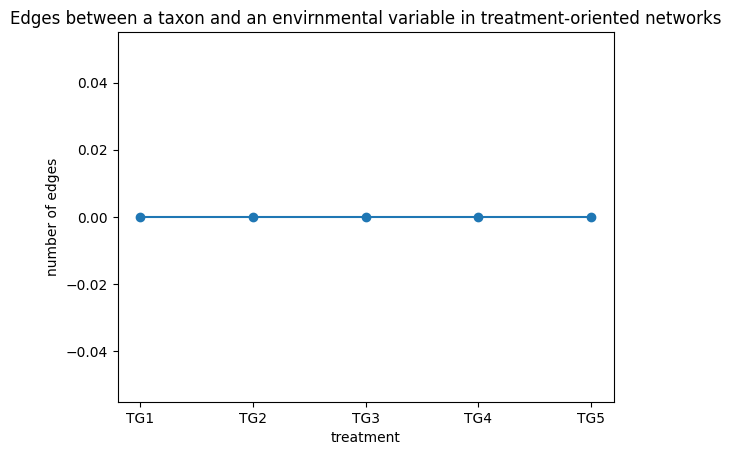

In [86]:
plt.plot(treatments, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and an envirnmental variable in treatment-oriented networks")

plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [139]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in treatment_parsed_nets.items()
]

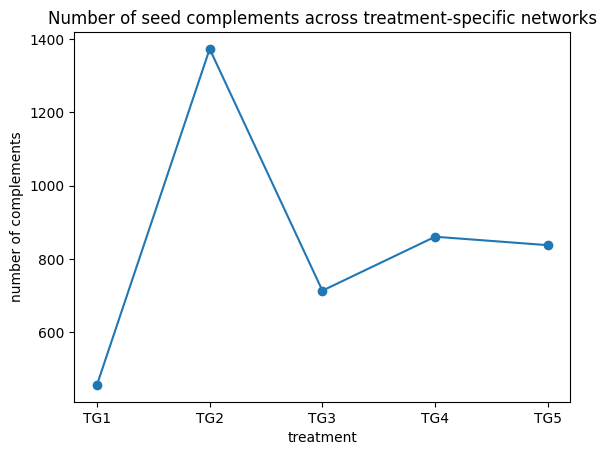

In [140]:
plt.plot(treatments, overall_number_of_seed_compl, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements across treatment-specific networks")

# Show the plot
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [141]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in treatment_parsed_nets.items()
]

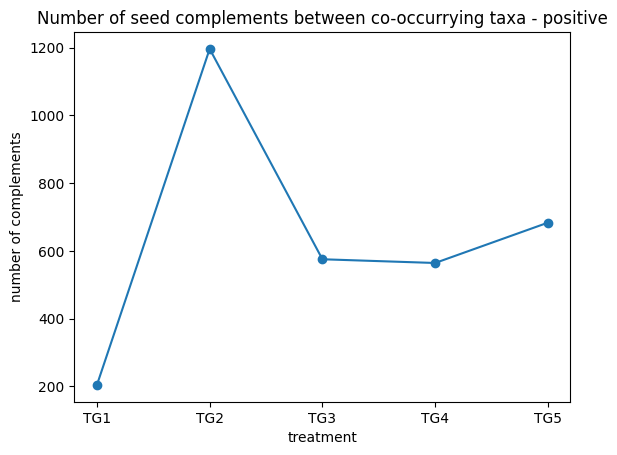

In [142]:
plt.plot(treatments, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")

# Show the plot
plt.show()

In [143]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(treatment_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(treatment_parsed_nets.values())
]

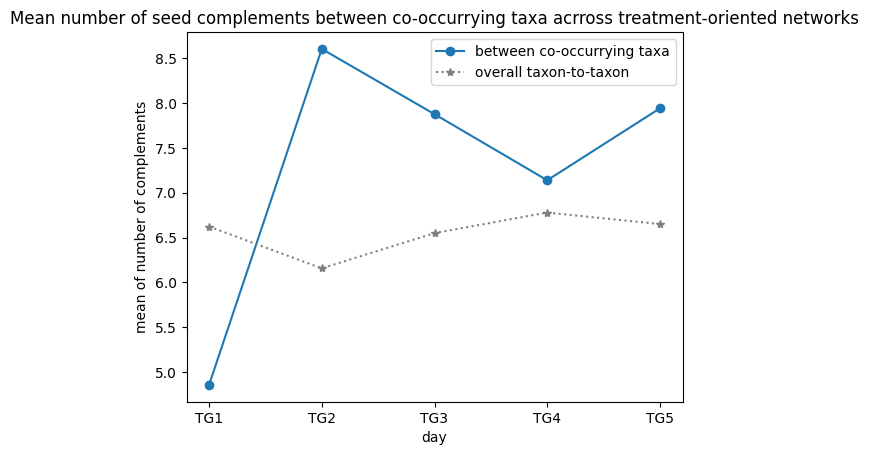

In [144]:
plt.plot(treatments, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(treatments, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")

# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross treatment-oriented networks")

plt.legend()

# Show the plot
plt.show()

#### Unique compounds involved in potential cross-feedings of co-occurrying taxa

In [145]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in treatment_parsed_nets.items()
]

lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

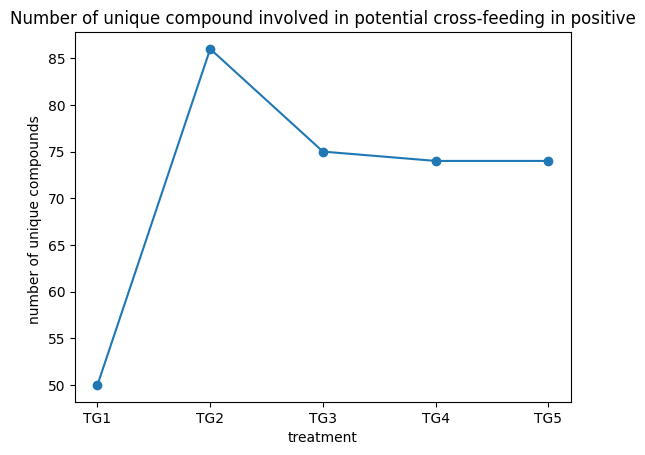

In [146]:
plt.plot(treatments, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [147]:
treatment_set = { i: j for i,j in zip(treatments, unique_compounds_in_cf_of_positive_associated_taxa)}

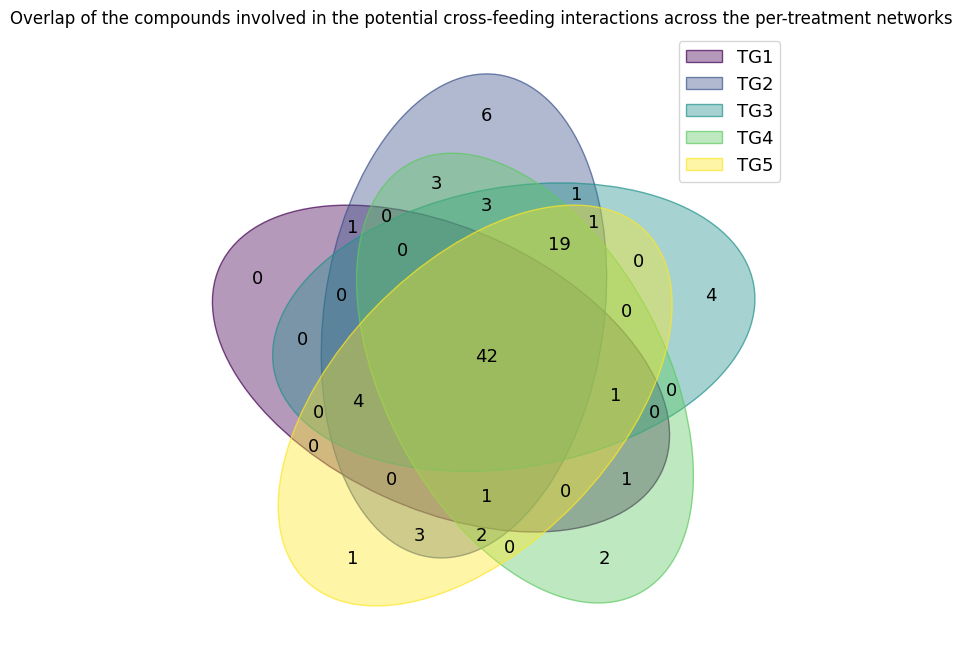

In [148]:
venn(treatment_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-treatment networks")

# Show the plot
plt.show()

In [149]:
dfs = {}

ratio_ggplots_wls, ratio_ggplots_ols = [], []

for _, treatment in enumerate(treatment_parsed_nets):

    tr_net = treatment_parsed_nets[treatment]

    df = process_cooccurrence_and_regression(
        tr_net, treatment, metabolites, env_set
    )

    dfs[treatment] = df


for treatment, df in dfs.items():

        ratio_ggplots_wls.append( plot_neighbors_per_seed_compl(df, treatment,  model="WLS") )  # or OLS
        ratio_ggplots_ols.append( plot_neighbors_per_seed_compl(df, treatment,  model="OLS") )

In [151]:

for treatment, case in zip(treatments, ratio_ggplots_wls):

    adf = case[1]
    adf["genome_size"] = adf["name"].map(genome_metadata.set_index("genome")["length"])
    adf["compls_per_neighbor"] = adf[COMPLEMENTS_NUMBER] / adf[NEIGHBORS_NUMBER]

    x = adf[NEIGHBORS_NUMBER]
    # y = adf[COMPLEMENTS_NUMBER]
    y = adf["compls_per_neighbor"]

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    model = smf.quantreg(f"{COMPLEMENTS_NUMBER} ~ {NEIGHBORS_NUMBER}", adf)
    res = model.fit(q=0.5)
    # Median regression coefficient for neighbors_num
    slope = res.params[NEIGHBORS_NUMBER]

    # Intercept
    intercept = res.params['Intercept']

    # p-value for the slope
    pval = res.pvalues[NEIGHBORS_NUMBER]

    # Pseudo R²
    pseudo_r2 = res.prsquared  # or res.rsquared if available# median regression
    print(res.summary())


    p = (
        ggplot(adf, aes(
            x     = NEIGHBORS_NUMBER,
            # y     = COMPLEMENTS_NUMBER,
            y = "compls_per_neighbor",
            color = 'order',              # assuming 'order' is a column
            size  = 'genome_size'         # map genome_size to point size
        ))
        + geom_point()
        + stat_smooth(method='lm', se=True, color='black')  # regression line
        + labs(
            color = 'Order',
            size  = 'Genome Size'
        )
        + theme_minimal()

        + labs(
        title = f"treatment {treatment} at the order level",
        x     = "Neighbors Number",
        # y     = "Seed Complements Number",
        y     = "Seed Complements per Neighbor",
        )
        + annotate(
            "text",
            x = adf[NEIGHBORS_NUMBER].max() * 0.8,
            y = adf["compls_per_neighbor"].max() * 0.9,
            label = f"Intercept = {intercept:.2f}\nSlope = {slope:.2f}\nPseudo R² = {pseudo_r2:.3f}\nP-value = {pval:.3g}",
            size = 10,
            color = "black",
        )

        # + annotate(
        #     "text",
        #     x     = adf[NEIGHBORS_NUMBER].max() * 0.8,
        #     y     = adf[RATIO].max() * 0.9,
        #     label = f"R² = {r_value:.3f}\nP-value = {p_value:.3g}",
        #     size  = 10,
        #     color = "black",
        # )
    )
    
    
    ggsave(
        p,
        filename = f"figs/seed_stats/{treatment}_family_wls.png",
        dpi      = 300,
        width    = 8,
        height   = 6
    )

                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.3490
Model:                       QuantReg   Bandwidth:                       11.80
Method:                 Least Squares   Sparsity:                        20.78
Date:                Thu, 30 Oct 2025   No. Observations:                   27
Time:                        13:28:02   Df Residuals:                       25
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.0000      4.755     -0.841      0.408     -13.792       5.792
neighbors_num    15.0000      3.529      4.250      0.000       7.731      22.269


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning:

Saving 8 x 6 in image.

/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning:

Filename: figs/seed_stats/TG1_family_wls.png



                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.4593
Model:                       QuantReg   Bandwidth:                       6.970
Method:                 Least Squares   Sparsity:                        17.90
Date:                Thu, 30 Oct 2025   No. Observations:                  101
Time:                        13:28:03   Df Residuals:                       99
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5000      2.054      0.243      0.808      -3.576       4.576
neighbors_num    11.5000      0.944     12.178      0.000       9.626      13.374


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning:

Saving 8 x 6 in image.

/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning:

Filename: figs/seed_stats/TG2_family_wls.png



                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.5485
Model:                       QuantReg   Bandwidth:                       6.323
Method:                 Least Squares   Sparsity:                        13.86
Date:                Thu, 30 Oct 2025   No. Observations:                   56
Time:                        13:28:04   Df Residuals:                       54
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3333      1.915      0.696      0.489      -2.505       5.172
neighbors_num    11.3333      0.998     11.353      0.000       9.332      13.335


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning:

Saving 8 x 6 in image.

/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning:

Filename: figs/seed_stats/TG3_family_wls.png



                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.4378
Model:                       QuantReg   Bandwidth:                       6.942
Method:                 Least Squares   Sparsity:                        15.72
Date:                Thu, 30 Oct 2025   No. Observations:                   61
Time:                        13:28:05   Df Residuals:                       59
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5000      2.308      0.650      0.518      -3.117       6.117
neighbors_num    11.5000      1.407      8.172      0.000       8.684      14.316


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning:

Saving 8 x 6 in image.

/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning:

Filename: figs/seed_stats/TG4_family_wls.png



                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.4944
Model:                       QuantReg   Bandwidth:                       8.009
Method:                 Least Squares   Sparsity:                        17.23
Date:                Thu, 30 Oct 2025   No. Observations:                   58
Time:                        13:28:06   Df Residuals:                       56
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9691      2.582      0.375      0.709      -4.204       6.142
neighbors_num    12.6770      1.320      9.605      0.000      10.033      15.321


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning:

Saving 8 x 6 in image.

/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning:

Filename: figs/seed_stats/TG5_family_wls.png



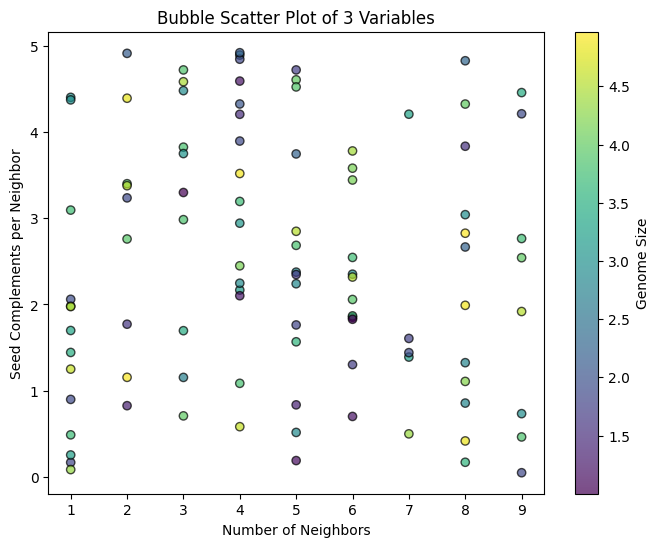

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
np.random.seed(0)
df = pd.DataFrame({
    'neighbors': np.random.randint(1, 10, 100),  # discrete
    'seed_complements': np.random.rand(100) * 5,  # float
    'genome_size': np.random.rand(100) * 4 + 1   # float
})

# --------- 1. Bubble scatter plot ---------
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df['neighbors'], 
    df['seed_complements'],
    # s=df['genome_size'],           # scale marker size
    c=df['genome_size'],              # color by genome size
    cmap='viridis', alpha=0.7, edgecolor='k'
)
plt.colorbar(scatter, label='Genome Size')
plt.xlabel('Number of Neighbors')
plt.ylabel('Seed Complements per Neighbor')
plt.title('Bubble Scatter Plot of 3 Variables')
plt.show()



In [ ]:
df.columns = [
    'id', 'num_neighbors', 'neighbors', 'seed_compls_num', 'name',
    'species', 'family', 'order', 'condition',
    'seed_complements_per_neighbor', 'genome_size'
]

In [ ]:
df.shape

In [ ]:
# should then be in the per-day, per-treat abd dfs
abd["mean_abundance"]
abd["genome-size"]


,genome,D300529,D300480,D300517,D300428,D300509,D300516,D300510,D300483,D300466,...,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497,classification
0,D300418:bin_000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
1,D300418:bin_000013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
2,D300428:bin_000008,0.000000,5.924637,6.827628,40.092190,28.253915,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Ch...
3,D300430:bin_000010,2.607789,4.819473,3.286938,17.597362,10.291956,10.220982,4.596655,7.567160,6.932594,...,16.838742,23.439109,10.233177,7.759339,12.926734,5.729738,12.526382,5.296297,0.000000,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
4,D300432:bin_000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,d__Bacteria;p__Bacillota_A;c__Clostridia;o__La...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,TG5_28:bin_000003,0.907506,5.072674,0.000000,0.000000,0.000000,0.909005,1.265050,0.847525,0.000000,...,19.097925,32.406827,8.486407,36.327935,15.803373,23.278688,24.773763,12.790131,7.361412,d__Bacteria;p__Bacillota;c__Bacilli;o__Erysipe...
219,TG5_28:bin_000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.573801,1.191014,...,8.572389,19.450774,2.263671,17.486717,16.178517,1.579626,17.645893,4.046051,1.721655,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...
220,TG5_35:bin_000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.237666,1.091515,3.520348,28.828782,21.528210,7.020633,13.706651,11.851864,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...
221,TG5_35:bin_000022,0.000000,0.000000,1.300227,0.827733,2.124066,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.551834,6.422410,12.654194,19.409241,9.396394,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Ch...


## Using `ndex2` to parse `microbetag` networks

In [32]:
from microbetagAnalyser import MicrobetagNetsAnalysis

In [33]:
# anal = MicrobetagNetsAnalysis("microbetag_nets/prev20/day_21.cx2")
anal = MicrobetagNetsAnalysis("microbetag_nets/prev20/per_day/")

In [17]:
interactors, interscetion = anal.get_stats_df()

In [19]:
interactors.head()

,type,total_edges,co-occurrence,co-exclusion,competition,cooperation
Lawsonibacter,taxon,46,12,6,28,0
Gemmiger avicola,taxon,46,11,5,30,0
Eisenbergiella sp904392525,taxon,43,12,3,28,0
Coproplasma stercorigallinarum,taxon,41,10,6,25,0
Copromonas faecavium,taxon,41,8,6,27,1


In [20]:
interscetion.head()

,occurrences_across_networks,interaction_types
L-Tyrosine-L-Phenylalanine,5,{co-occurrence}
Mediterraneibacter sp900761655-treatment_TG3,4,{co-occurrence}
Eisenbergiella merdigallinarum-Lactobacillus johnsonii,4,"{co-occurrence, competition, co-exclusion}"
L-Leucine-L-Isoleucine,4,{co-occurrence}
L-Alanine-Lactic acid,3,{co-occurrence}


In [21]:
anal.taxonomic_level = 'family'

In [22]:
interactors_fam, interscetion_fam = anal.get_stats_df()

Recomputing stats for taxonomic level: family...


In [23]:
interactors_fam.head()

,type,total_edges,co-occurrence,co-exclusion,competition,cooperation
Lachnospiraceae,taxon,1037,300,107,630,5
Oscillospiraceae,taxon,448,109,58,281,5
Acutalibacteraceae,taxon,366,98,42,226,2
Ruminococcaceae,taxon,311,80,42,189,1
Borkfalkiaceae,taxon,219,68,19,132,1


In [24]:
interactors_fam.head()

,type,total_edges,co-occurrence,co-exclusion,competition,cooperation
Lachnospiraceae,taxon,1037,300,107,630,5
Oscillospiraceae,taxon,448,109,58,281,5
Acutalibacteraceae,taxon,366,98,42,226,2
Ruminococcaceae,taxon,311,80,42,189,1
Borkfalkiaceae,taxon,219,68,19,132,1


In [21]:
all_nets = {
    "7" : cx_07,
    "14" : cx_14,
    "21" : cx_21,
    "28" : cx_28,
    "35" : cx_35,
    "TG1"   : cx_tg_1,
    "TG2"   : cx_tg_2,
    "TG3"   : cx_tg_3,
    "TG4"   : cx_tg_4,
    "TG5"   : cx_tg_5,
    "global": cx_overall
}

associations_per_net = {}

for name, network in all_nets.items():

    associations_per_net[name] = []

    for _,  edge in network.get_edges().items():

        source = network.get_node(edge["s"])["v"]["name"]
        target = network.get_node(edge["t"])["v"]["name"]
        if 'microbetag::weight' in edge["v"]:
            weight = edge["v"]['microbetag::weight']

            associations_per_net[name].append([source, target, weight])



output_file = "associations.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    for name, associations in associations_per_net.items():
        df = pd.DataFrame(associations)
        df.columns = ["A", "B", "weight"]
        # Write each dataframe to a sheet named after 'name'
        df.to_excel(writer, sheet_name=name, index=False)

In [27]:
import gzip
import json
import pandas as pd

In [26]:
with gzip.open("mgg_prec/pathway_complementarity/pathway_complements_extended.json.gz") as f:
    c = json.load(f)

In [ ]:
hits = {}
for i in c:
    hits[i] = {}
    for j in c[i]:
        hits[i][j] = len(c[i][j])

In [29]:
df = pd.DataFrame(hits)

In [31]:
flat = df.stack()  # each value indexed by (row, column)

In [49]:
sorted_values = flat.sort_values(ascending=False)

# cumulative sum
cumsum = sorted_values.cumsum()

# 99% threshold
threshold = 0.05 * sorted_values.sum()

# find the first value where cumulative sum >= threshold
vline_index = np.searchsorted(cumsum.values, threshold)
vline_value = sorted_values.iloc[vline_index]

In [50]:
print("Value at 99% cumulative abundance:", vline_value)

Value at 99% cumulative abundance: 85


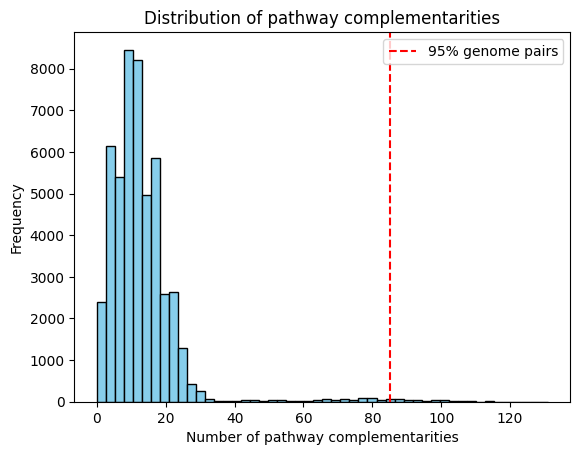

In [57]:
plt.hist(flat.values, bins=50, color="skyblue", edgecolor="black")
plt.axvline(vline_value, color="red", linestyle="dashed", label="95% genome pairs")
plt.xlabel("Number of pathway complementarities")
plt.ylabel("Frequency")
plt.title("Distribution of pathway complementarities")
plt.legend()
plt.show()


In [82]:
with open("mgg_prec/seeds_complementarity/kegg_module_related_seeds.pkl", "rb") as f:
    seeds = pickle.load(f)

with open("mgg_prec/seeds_complementarity/kegg_module_related_nonseeds.pkl", "rb") as f:
    nonseeds = pickle.load(f)

In [83]:
seed_counts = pd.Series([cpd for lst in seeds[0] for cpd in lst]).value_counts()

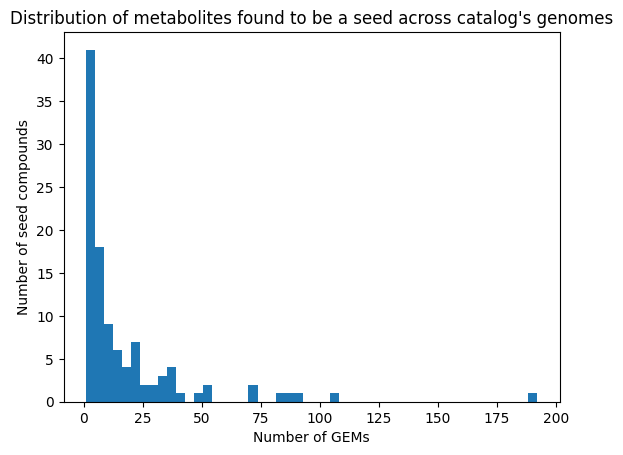

In [95]:
plt.hist(seed_counts, bins=50)
plt.xlabel("Number of GEMs")
plt.ylabel("Number of seed compounds")
plt.title("Distribution of metabolites found to be a seed across catalog's genomes")
plt.show()


In [232]:
seed_counts[seed_counts > 25]

cpd00727    192
cpd01260    107
cpd00268     89
cpd00153     87
cpd00220     83
cpd00075     72
cpd00305     72
cpd00235     53
cpd00485     51
cpd00259     50
cpd00344     41
cpd00118     39
cpd00051     39
cpd00599     37
cpd00134     36
cpd00644     33
cpd00794     33
cpd03128     33
cpd00098     29
cpd01741     29
cpd00209     26
cpd01695     26
Name: count, dtype: int64

In [90]:
nonseeds_unique = nonseeds[0].apply(set)
nonseed_counts  = pd.Series([cpd for lst in nonseeds_unique for cpd in lst]).value_counts()

In [85]:
nonseed_counts = pd.Series([cpd for lst in nonseeds[0] for cpd in lst]).value_counts()

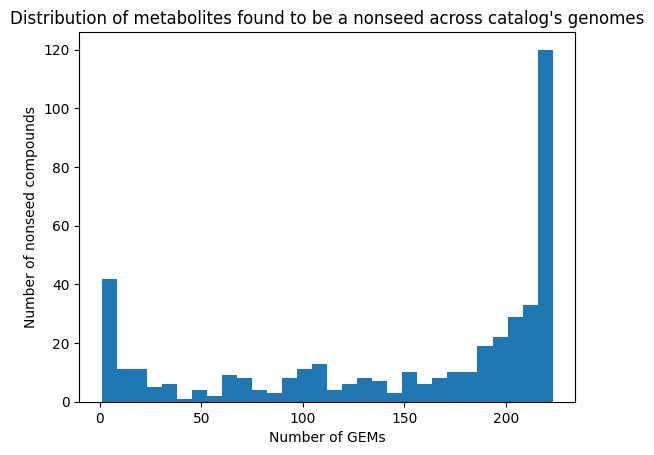

In [92]:
plt.hist(nonseed_counts, bins=30)
plt.xlabel("Number of GEMs")
plt.ylabel("Number of nonseed compounds")
plt.title("Distribution of metabolites found to be a nonseed across catalog's genomes")
plt.show()


In [ ]:
def jaccard(A, B):
    # Intersection /  union 
    return len(A & B) / len(A | B) if A | B else 0

seed_seed_jacc = []
seed_nonseed_jacc = []

for sp1, sp2 in itertools.permutations(list(seeds.index), 2):
    S1 = set(seeds[0][sp1])
    S2 = set(seeds[0][sp2])
    N2 = set(nonseeds[0][sp2])

    seed_seed_jacc.append(jaccard(S1, S2))
    seed_nonseed_jacc.append(jaccard(S1, N2))

In [168]:
def jaccard(A, B):
    return len(A & B) / len(A | B) if A | B else 0

In [175]:
a = set(["a", "b"])
b = set(["a", "d", "e", "j"])

In [177]:
a & b

{'a'}

In [178]:
a | b

{'a', 'b', 'd', 'e', 'j'}

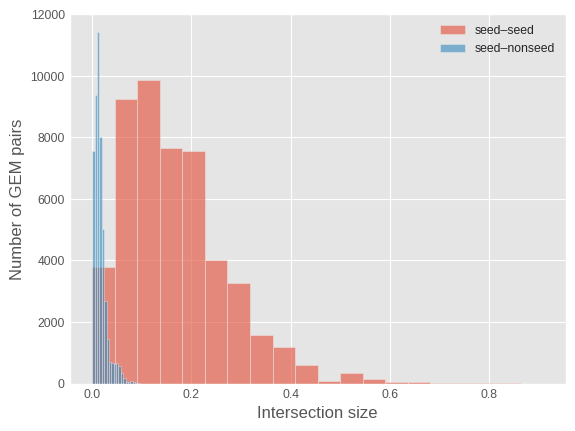

In [208]:
import matplotlib.pyplot as plt

plt.hist(seed_seed_jacc, bins=20, alpha=0.6, label="seed–seed")
plt.hist(seed_nonseed_jacc, bins=20, alpha=0.6, label="seed–nonseed")
plt.style.use("seaborn-v0_8-whitegrid")  # clean, publication-friendly
plt.style.use("ggplot")
# plt.style.use("tableau-colorblind10")  # colorblind-safe
plt.xlabel("Intersection size")
plt.ylabel("Number of GEM pairs")
# plt.title("Distribution of seed–seed and seed–nonseed Jaccard similarities across catalog GEMs")
plt.legend()

plt.show()


In [ ]:
ratio = seed_seed_jacc / seed_nonseed_jacc
print(len(ratio))
ratio = ratio[np.isfinite(ratio)]  # remove inf and nan
print(len(ratio))

# Small pseudocount to avoid log(0)
eps = 1e-6
log2_ratio = np.log2((seed_seed_jacc + eps) / (seed_nonseed_jacc + eps))


print("Median log2 fold change:", np.median(log2_ratio))
print("Mean log2 fold change:", np.mean(log2_ratio))


49506
46633
Median log2 fold change: 3.5311816380089223
Mean log2 fold change: 3.3545348229476177


/tmp/ipykernel_18124/2447432984.py:1: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_18124/2447432984.py:1: RuntimeWarning: invalid value encountered in divide


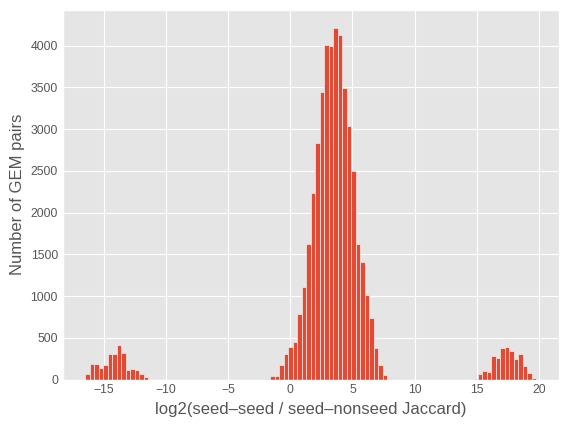

In [228]:
plt.hist(log2_ratio, bins=100)
plt.style.use("seaborn-v0_8-whitegrid")  # clean, publication-friendly
plt.style.use("ggplot")
plt.xlabel("log2(seed–seed / seed–nonseed Jaccard)")
plt.ylabel("Number of GEM pairs")
# plt.title("Relative increase of seed–seed over seed–nonseed Jaccard similarity")
plt.show()


In [206]:
diff = seed_seed_jacc - seed_nonseed_jacc

print("Median difference:", np.median(diff))
print("Mean difference:", np.mean(diff))


Median difference: 0.13101604278074866
Mean difference: 0.14775217770545246


In [116]:
from scipy.stats import mannwhitneyu

u, p = mannwhitneyu(seed_seed_jacc, seed_nonseed_jacc, alternative='greater')
print("U =", u, "p =", p)


U = 2312417341.0 p = 0.0


In [158]:
np.mean(seed_seed_jacc)

0.13333333333333333

In [162]:
np.mean(seed_nonseed_jacc)

0.0297029702970297

In [119]:
species = list(seeds.index)

In [ ]:
results = []
for spA, spB in itertools.permutations(species, 2):
    S_A = set(seeds[0][spA])
    S_B = set(seeds[0][spB])
    N_B = set(nonseeds[0][spB])
    
    # Jaccard metrics
    seed_seed_jacc    = jaccard(S_A, S_B)
    seed_nonseed_jacc = jaccard(S_A, N_B)

    # Fold ratio: size of seed set A / intersection with B's seed ∪ nonseed
    U_B = S_B | N_B

    intersection_size = len(S_A & U_B)

    fold_ratio        = len(S_A) / intersection_size if intersection_size > 0 else float('inf')
    
    results.append({
        'species_A': spA,
        'species_B': spB,
        'seed_seed_jacc': seed_seed_jacc,
        'seed_nonseed_jacc': seed_nonseed_jacc,
        'fold_ratio': fold_ratio
    })

# Convert to tidy DataFrame
df_results = pd.DataFrame(results)

In [143]:
a=df_results['fold_ratio'].sort_values()

In [152]:
223*223-223


49506

In [155]:
len(a)

49506

In [156]:
a[a==1]

9184     1.0
32062    1.0
9117     1.0
9120     1.0
9156     1.0
        ... 
4435     1.0
6436     1.0
18387    1.0
6435     1.0
18336    1.0
Name: fold_ratio, Length: 12347, dtype: float64

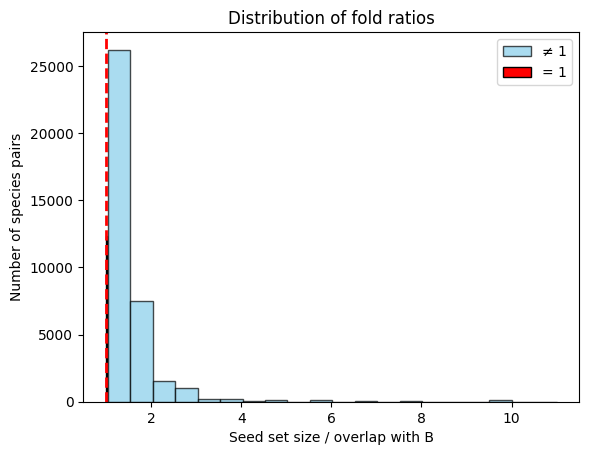

In [164]:
import matplotlib.pyplot as plt

# Replace infinities for plotting
folds_plot = df_results['fold_ratio'].replace(float('inf'), 10)

# Split values
exactly_one = folds_plot[folds_plot == 1]
others = folds_plot[folds_plot != 1]

plt.hist(others, bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='≠ 1')
plt.hist(exactly_one, bins=[0.99, 1.01], color='red', edgecolor='black', label='= 1')  # tiny bin around 1

plt.axvline(1, color='red', linestyle='--', linewidth=2)
plt.xlabel("Seed set size / overlap with B")
plt.ylabel("Number of species pairs")
plt.title("Distribution of fold ratios")
plt.legend()
plt.show()


In [157]:
12347/49506

0.24940411263281217

/tmp/ipykernel_18124/1086945908.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



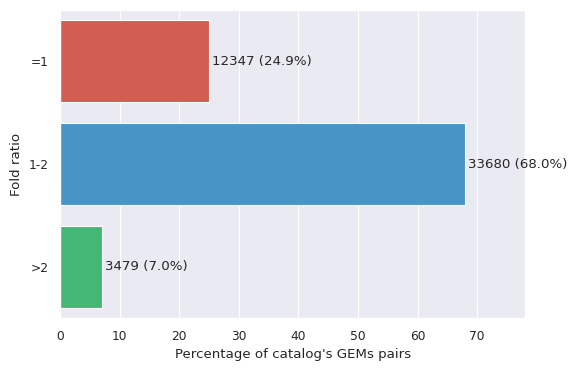

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Categorize fold ratios
folds      = df_results['fold_ratio'].replace(float('inf'), 10)
categories = pd.cut(folds, bins=[0, 1, 2, folds.max()], right=True, labels=['=1', '1-2', '>2'], include_lowest=True)
counts     = categories.value_counts().sort_index()

# Convert to percentage
percent = 100 * counts / counts.sum()

# Plot
# sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
# plt.style.use("seaborn-v0_8-whitegrid")  # clean, publication-friendly
# plt.style.use("tableau-colorblind10")  # colorblind-safe
sns.set_theme(style="darkgrid", context="paper")

bars = sns.barplot(x=percent.values, y=percent.index, palette=['#E74C3C', '#3498DB', '#2ECC71'])

# Annotate bars with counts and percentage
for bar, count, p in zip(bars.patches, counts.values, percent.values):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{count} ({p:.1f}%)", va='center')

plt.xlabel("Percentage of catalog's GEMs pairs")
plt.ylabel("Fold ratio")
    # intersection_size = len(S_A & U_B)

    # fold_ratio        = len(S_A) / intersection_size if intersection_size > 0 else float('inf')
    
# plt.title("Distribution of fold ratios of seeds_A length to its intersection with the total compounds of GEM B")
plt.xlim(0, max(percent.values) + 10)


plt.show()
